In [1]:
import pandas as pd
import numpy as np
import json
import re
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')

# install required env

In [2]:
#! pip install pytorch-pretrained-bert
! pip install spacy ftfy==4.4.3
! python -m spacy download en
! pip install regex

     |████████████████████████████████| 51kB 6.1MB/s 
  Stored in directory: /root/.cache/pip/wheels/37/54/00/d320239bfc8aad1455314f302dd82a75253fc585e17b81704e
Successfully built ftfy
✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')
✔ Linking successful
/usr/local/lib/python3.6/dist-packages/en_core_web_sm -->
/usr/local/lib/python3.6/dist-packages/spacy/data/en
You can now load the model via spacy.load('en')
     |████████████████████████████████| 655kB 8.8MB/s 
  Stored in directory: /root/.cache/pip/wheels/35/e4/80/abf3b33ba89cf65cd262af8a22a5a999cc28fbfabea6b38473
Successfully built regex


In [ ]:
#! pip install torchsnooper

In [3]:
! pip install tqdm tensorboardX livelossplot

     |████████████████████████████████| 245kB 10.0MB/s 


In [5]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [2]:
import logging
import torch
logging.basicConfig(level=logging.INFO)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


# Load Data

In [3]:
import sys
#sys.path.append('./gdrive/My Drive/deepqa_features/')
sys.path.append('../../')

In [4]:
from deepqa_models import TextNormalization, MultiLabel_Vectorizer, DocProcessor

INFO:pytorch_pretrained_bert.modeling:Better speed can be achieved with apex installed from https://www.github.com/nvidia/apex .


## Text Classification Dataset

In [ ]:
text_clf_file = './gdrive/My Drive/deepqa_features/data/cuishou_text_intent.csv'

In [ ]:
text_clf_df = pd.read_csv(text_clf_file, encoding='gbk', sep='\t')

In [10]:
text_clf_df.head()

,label,text
0,表明来意,噢您好，我们这边是金葫芦公司的，您在这边有一个欠款，啊
1,有意愿还款,啊就想知道那个我手机出了问题，那个你们那个APP本都不见了，然后我找不到这块，下面加个微信，...
2,表明来意,我们这边是那个嗯金湖路公司的，您在这边有一笔欠款怎么还没处理事忘了吗？
3,表明来意,金葫芦公司的，您在这边有一笔欠款怎么还没处理丫，你是忘了吗？
4,核资,能还上吗！


In [ ]:
tn = TextNormalization(stop_words='./gdrive/My Drive/deepqa_features/data/chinese_punct.json')

In [12]:
clean_text = tn.fit_transform(text_clf_df['text'])
print(len(clean_text))

Building prefix dict from the default dictionary ...
DEBUG:jieba:Building prefix dict from the default dictionary ...


level  2
Process multiple sentences ===> 


Dumping model to file cache /tmp/jieba.cache
DEBUG:jieba:Dumping model to file cache /tmp/jieba.cache
Loading model cost 0.985 seconds.
DEBUG:jieba:Loading model cost 0.985 seconds.
Prefix dict has been built succesfully.
DEBUG:jieba:Prefix dict has been built succesfully.


3885


In [ ]:
y_mvec = MultiLabel_Vectorizer(onehot=False)

In [14]:
y_mvec.fit(text_clf_df['label'])
y_label = y_mvec.transform(text_clf_df['label'])
print(y_label.shape)

(3885,)


In [15]:
doc_proc = DocProcessor()
doc_proc.fit(text_clf_df['text'])

level  2
Process multiple sentences ===> 
level  2
Process multiple sentences ===> 


In [ ]:
doc_lens, seq_lens = doc_proc.get_docs_sents_length_no_pad(text_clf_df['text'])

In [17]:
np.percentile(doc_lens, 95)

77.0

In [18]:
max_seq_len = 80
n_labels = y_mvec.n_labels
label_list = y_mvec.unique_labels
label_map = y_mvec.label2int_dict

print(max_seq_len, n_labels, label_list, '\n'  , label_map)

80 12 ['询问关系', '有意愿还款', '第三人还款', '礼貌挂断', '标准开场', '施压警告', '核资', '表明来意', '无意愿还款', '客户抱怨', '无还款能力', '有助于还款'] 
 {'询问关系': 0, '有意愿还款': 1, '第三人还款': 2, '礼貌挂断': 3, '标准开场': 4, '施压警告': 5, '核资': 6, '表明来意': 7, '无意愿还款': 8, '客户抱怨': 9, '无还款能力': 10, '有助于还款': 11}


## NER Dataset

In [ ]:
text_ner_file = './gdrive/My Drive/deepqa_features/data/ner_data.csv'

In [ ]:
text_ner_df = pd.read_csv(text_ner_file)

In [50]:
text_ner_df.head()

,sentence,tag
0,海 钓 比 赛 地 点 在 厦 门 与 金 门 之 间 的 海 域 。,O O O O O O O B-LOC I-LOC O B-LOC I-LOC O O O ...
1,这 座 依 山 傍 水 的 博 物 馆 由 国 内 一 流 的 设 计 师 主 持 设 计 ...,O O O O O O O O O O O O O O O O O O O O O O O ...
2,但 作 为 一 个 共 产 党 员 、 人 民 公 仆 ， 应 当 胸 怀 宽 阔 ， 真 ...,O O O O O O O O O O O O O O O O O O O O O O O ...
3,在 发 达 国 家 ， 急 救 保 险 十 分 普 及 ， 已 成 为 社 会 保 障 体 ...,O O O O O O O O O O O O O O O O O O O O O O O ...
4,日 俄 两 国 国 内 政 局 都 充 满 变 数 ， 尽 管 日 俄 关 系 目 前 是 ...,B-LOC B-LOC O O O O O O O O O O O O O O B-LOC ...


In [51]:
y_ner_proc = DocProcessor(use_end=True, use_start=False, use_unk=False, use_pad=True) 
y_ner_proc.fit(text_ner_df['tag'])

level  2
Process multiple sentences ===> 
level  2
Process multiple sentences ===> 


In [52]:
n_labels = y_ner_proc.vocab_size
print(n_labels, y_ner_proc.max_seq_len, y_ner_proc.word2index)

9 577 {'<pad>': 0, '<eos>': 1, 'O': 2, 'B-LOC': 3, 'I-LOC': 4, 'B-PER': 5, 'I-PER': 6, 'B-ORG': 7, 'I-ORG': 8}


In [53]:
y_ner_proc.word2index

{'<eos>': 1,
 '<pad>': 0,
 'B-LOC': 3,
 'B-ORG': 7,
 'B-PER': 5,
 'I-LOC': 4,
 'I-ORG': 8,
 'I-PER': 6,
 'O': 2}

## Phrase Sim Dataset

In [ ]:
text_phrase_file = './gdrive/My Drive/deepqa_features/data/cuishou_phrase_inference.csv'

In [ ]:
text_phrase_df = pd.read_csv(text_phrase_file,encoding='gbk', sep='\t')

In [64]:
text_phrase_df.head()

,label,sentence_A,sentence_B
0,0,唉 我 这边 缴费 的 麻烦 你 必须 要 打个 电话 给 你 处理 一下 描述 的 欠款 ...,嗯 嗯 再见
1,0,你 不能 不能 我 尽量 快点,您好 我 这边 是 我 想 借 公司 的 你 在 我 想 借 的 欠款 已经 逾期 了 现在...
2,0,唉 你好 我 想 借 贷款 这边 逾期 怎么 一直 没 处理 啊,嗯 六点 之前 可以 啊 只要 您 这 段时间 你 能 确保 把 这个 钱 还 进来 可以 ...
3,0,今天 还接 不了 你 跟 我 说 的 是 点到 点 之间 肯定 发工资 是 吧 肯定 会 结账 的,你好 我 这边 是 这个 金葫芦 的 你 在 金 湖路 一笔 欠款 今天 是 还款 日 您 ...
4,1,嗯 其他 没有 走 没有 转,是 什么 的 因为 这 两天 小孩 在 住院 不行 你 说


In [ ]:
p_proc = DocProcessor()

doc_a, sent_a = p_proc.get_docs_sents_length_no_pad(text_phrase_df['sentence_A'])
doc_b, sent_a = p_proc.get_docs_sents_length_no_pad(text_phrase_df['sentence_B'])

In [69]:
print(np.max(doc_a), np.max(doc_b) ,'\n', np.percentile(doc_a, 95), np.percentile(doc_b, 95) )

315 315 
 120.0 109.0


In [ ]:
max_seq_length = 120

## QA UCAC dataset

In [ ]:
ucac_train_file = './gdrive/My Drive/deepqa_features/data/ucac_qa/train.csv'

In [ ]:
#ucac_data = pd.read_json(ucac_train_file, lines=True)
ucac_train_df = pd.read_csv(ucac_train_file)

In [25]:
ucac_train_df.head()

,is_selected,passage,passage_id,question,question_id
0,0,键能和解离能有什么区别 由键能求焓变公式：δh=反应物的总键能-生成物的总键能,9,键能和解离能有什么区别,10133193
1,0,hold住是什么意思？网络用语hold住的起源 整个场面我要hold住 表演结束后，miss...,4,我hold得住了是什么意思,10072299
2,0,如何理解法的古老含义和现代特征 （三）现代社会法的特征 现代社会的法，虽然也有刑法，对犯罪分...,20,如何理解法的特征,10052345
3,0,上海-东京-大溪地，签证和行李问题请教打什么～ 问题3.日本的签证停留期是15天，若回上海...,16,去大溪地行李直挂问题,10037814
4,0,水浒传：二龙山兴衰史 不久后，武松因为醉打蒋门神被陷害，几乎被设计杀死。最终凭借高超的武艺，...,7,水浒传里的二龙山,10089946


In [26]:
ucac_train_df['is_selected'].nunique()

2

In [27]:
ucac_train_df['is_selected'].value_counts(normalize=True)

0    0.8627
1    0.1373
Name: is_selected, dtype: float64

In [ ]:
p_proc = DocProcessor()

doc_a, sent_a = p_proc.get_docs_sents_length_no_pad(ucac_train_df['passage'])
doc_b, sent_a = p_proc.get_docs_sents_length_no_pad(ucac_train_df['question'])

In [30]:
print(np.max(doc_a), np.max(doc_b), np.percentile(doc_a,95), np.percentile(doc_b, 95))

104510 87 388.0 18.0


In [38]:
doc_seq_len = 388
query_seq_len = 18
max_seq_len = doc_seq_len + query_seq_len
print(max_seq_len)

406


In [ ]:
label_map = {0:0, 1:1}

## Aspect sentiment

In [6]:
#aspect_prefix = './gdrive/My Drive/deepqa_features/data/data_after_process/aspect_term/2014_laptop/'
aspect_prefix = '../../data/Experiment/data_after_process/aspect_term/2014_laptop/'

In [7]:
aspect_laptop_train = aspect_prefix + 'train.csv'
aspect_laptop_test = aspect_prefix + 'test.csv'

In [8]:
laptop_train_df = pd.read_csv(aspect_laptop_train)

In [9]:
laptop_train_df.head()

,polarity,sentence,term
0,0,I charge it at night and skip taking the $T$ w...,cord
1,1,I charge it at night and skip taking the cord ...,battery life
2,-1,The tech guy then said the $T$ does not do 1-t...,service center
3,-1,The tech guy then said the service center does...,`` sales '' team
4,0,The $T$ then said the service center does not ...,tech guy


In [10]:
laptop_test_df = pd.read_csv(aspect_laptop_test)
laptop_test_df.head()

,polarity,sentence,term
0,1,i think the $T$ is very nice but the operating...,computer screen
1,-1,i think the computer screen is very nice but t...,operating system
2,1,"I am pleased with $T$ , but the windows 8 oper...",the life of battery
3,-1,"I am pleased with the life of battery , but th...",windows 8 operating system
4,1,"$T$ is super fast , around anywhere from 35 s...",Boot time


In [11]:
def fill_token(sent, term):
  #print(sent, term)
  return sent.replace('$T$', term)

In [12]:
laptop_train_df['sent'] = laptop_train_df.apply(lambda x: fill_token(x[1], x[2]), axis=1)

In [13]:
p_proc = DocProcessor()

doc_a, sent_a = p_proc.get_docs_sents_length_no_pad(laptop_train_df['sent'])

In [14]:
print(np.max(doc_a), np.percentile(doc_a, 90))

471 185.0


In [15]:
max_seq_len = 474

In [16]:
laptop_train_df['polarity'].value_counts()

 1    994
-1    870
 0    464
Name: polarity, dtype: int64

In [17]:
label_map = {1:2, -1:0, 0:1}

# Bert Notes

In [9]:
import torch
import torchsnooper

device = torch.device('cuda')
print(device)

@torchsnooper.snoop()
def myfunc(mask, x):
    y = torch.zeros(6).to(device)
    y.masked_scatter_(mask, x)
    return y

mask = torch.tensor([0, 1, 0, 1, 1, 0], device='cuda')
source = torch.tensor([1.0, 2.0, 3.0], device='cuda')
y = myfunc(mask, source).to(device)


cuda


Starting var:.. mask = tensor<(6,), int64, cuda:0>
Starting var:.. x = tensor<(3,), float32, cuda:0>
12:52:23.904396 call         8 def myfunc(mask, x):
12:52:23.904551 line         9     y = torch.zeros(6).to(device)
New var:....... y = tensor<(6,), float32, cuda:0>
12:52:23.904767 line        10     y.masked_scatter_(mask, x)
12:52:23.908930 exception   10     y.masked_scatter_(mask, x)
RuntimeError: Expected object of scalar type Byte but got scalar type Long for argument #2 'mask'
Call ended by exception


RuntimeError: ignored

In [10]:
import torch
from pytorch_pretrained_bert import BertTokenizer, BertModel, BertForMaskedLM

# OPTIONAL: if you want to have more information on what's happening, activate the logger as follows
import logging
logging.basicConfig(level=logging.INFO)

# Load pre-trained model tokenizer (vocabulary)
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Tokenized input
text = "[CLS] Who was Jim Henson ? [SEP] Jim Henson was a puppeteer [SEP]"
tokenized_text = tokenizer.tokenize(text)

# Mask a token that we will try to predict back with `BertForMaskedLM`
masked_index = 8
tokenized_text[masked_index] = '[MASK]'
assert tokenized_text == ['[CLS]', 'who', 'was', 'jim', 'henson', '?', '[SEP]', 'jim', '[MASK]', 'was', 'a', 'puppet', '##eer', '[SEP]']

# Convert token to vocabulary indices
indexed_tokens = tokenizer.convert_tokens_to_ids(tokenized_text)
# Define sentence A and B indices associated to 1st and 2nd sentences (see paper)
segments_ids = [0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1]

# Convert inputs to PyTorch tensors
tokens_tensor = torch.tensor([indexed_tokens])
segments_tensors = torch.tensor([segments_ids])

INFO:pytorch_pretrained_bert.file_utils:https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-uncased-vocab.txt not found in cache, downloading to /tmp/tmpnk4b1_yq
100%|██████████| 231508/231508 [00:00<00:00, 2331844.27B/s]
INFO:pytorch_pretrained_bert.file_utils:copying /tmp/tmpnk4b1_yq to cache at /root/.pytorch_pretrained_bert/26bc1ad6c0ac742e9b52263248f6d0f00068293b33709fae12320c0e35ccfbbb.542ce4285a40d23a559526243235df47c5f75c197f04f37d1a0c124c32c9a084
INFO:pytorch_pretrained_bert.file_utils:creating metadata file for /root/.pytorch_pretrained_bert/26bc1ad6c0ac742e9b52263248f6d0f00068293b33709fae12320c0e35ccfbbb.542ce4285a40d23a559526243235df47c5f75c197f04f37d1a0c124c32c9a084
INFO:pytorch_pretrained_bert.file_utils:removing temp file /tmp/tmpnk4b1_yq
INFO:pytorch_pretrained_bert.tokenization:loading vocabulary file https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-uncased-vocab.txt from cache at /root/.pytorch_pretrained_bert/26bc1ad6c0ac742e9b52263248f6d0f0006

In [16]:
# Load pre-trained model (weights)
model = BertModel.from_pretrained('bert-base-uncased')
model.eval()

# If you have a GPU, put everything on cuda
tokens_tensor = tokens_tensor.to('cuda')
segments_tensors = segments_tensors.to('cuda')
model.to('cuda')

# Predict hidden states features for each layer
with torch.no_grad():
    encoded_layers, _ = model(tokens_tensor, segments_tensors)
# We have a hidden states for each of the 12 layers in model bert-base-uncased
assert len(encoded_layers) == 12

INFO:pytorch_pretrained_bert.file_utils:https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-uncased.tar.gz not found in cache, downloading to /tmp/tmp_cj3fame
100%|██████████| 407873900/407873900 [00:06<00:00, 65159992.58B/s]
INFO:pytorch_pretrained_bert.file_utils:copying /tmp/tmp_cj3fame to cache at /root/.pytorch_pretrained_bert/9c41111e2de84547a463fd39217199738d1e3deb72d4fec4399e6e241983c6f0.ae3cef932725ca7a30cdcb93fc6e09150a55e2a130ec7af63975a16c153ae2ba
INFO:pytorch_pretrained_bert.file_utils:creating metadata file for /root/.pytorch_pretrained_bert/9c41111e2de84547a463fd39217199738d1e3deb72d4fec4399e6e241983c6f0.ae3cef932725ca7a30cdcb93fc6e09150a55e2a130ec7af63975a16c153ae2ba
INFO:pytorch_pretrained_bert.file_utils:removing temp file /tmp/tmp_cj3fame
INFO:pytorch_pretrained_bert.modeling:loading archive file https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-uncased.tar.gz from cache at /root/.pytorch_pretrained_bert/9c41111e2de84547a463fd39217199738d1e3deb7

In [17]:
# Load pre-trained model (weights)
model = BertForMaskedLM.from_pretrained('bert-base-uncased')
model.eval()

# If you have a GPU, put everything on cuda
tokens_tensor = tokens_tensor.to('cuda')
segments_tensors = segments_tensors.to('cuda')
model.to('cuda')

# Predict all tokens
with torch.no_grad():
    predictions = model(tokens_tensor, segments_tensors)

# confirm we were able to predict 'henson'
predicted_index = torch.argmax(predictions[0, masked_index]).item()
predicted_token = tokenizer.convert_ids_to_tokens([predicted_index])[0]
assert predicted_token == 'henson'

INFO:pytorch_pretrained_bert.modeling:loading archive file https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-uncased.tar.gz from cache at /root/.pytorch_pretrained_bert/9c41111e2de84547a463fd39217199738d1e3deb72d4fec4399e6e241983c6f0.ae3cef932725ca7a30cdcb93fc6e09150a55e2a130ec7af63975a16c153ae2ba
INFO:pytorch_pretrained_bert.modeling:extracting archive file /root/.pytorch_pretrained_bert/9c41111e2de84547a463fd39217199738d1e3deb72d4fec4399e6e241983c6f0.ae3cef932725ca7a30cdcb93fc6e09150a55e2a130ec7af63975a16c153ae2ba to temp dir /tmp/tmphyllpbmk
INFO:pytorch_pretrained_bert.modeling:Model config {
  "attention_probs_dropout_prob": 0.1,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "max_position_embeddings": 512,
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "type_vocab_size": 2,
  "vocab_size": 30522
}

INFO:pytorch_pretrained_bert.modeling:Weights from pretrained model not 

In [ ]:
import torch
from pytorch_pretrained_bert import BertTokenizer, BertModel, BertForMaskedLM

# OPTIONAL: if you want to have more information on what's happening, activate the logger as follows
import logging
logging.basicConfig(level=logging.INFO)

# Load pre-trained model tokenizer (vocabulary)
tokenizer = BertTokenizer.from_pretrained('bert-base-chinese')

# Tokenized input
text = "[CLS] Who was Jim Henson ? [SEP] Jim Henson was a puppeteer [SEP]"
tokenized_text = tokenizer.tokenize(text)

# Mask a token that we will try to predict back with `BertForMaskedLM`
masked_index = 8
tokenized_text[masked_index] = '[MASK]'
assert tokenized_text == ['[CLS]', 'who', 'was', 'jim', 'henson', '?', '[SEP]', 'jim', '[MASK]', 'was', 'a', 'puppet', '##eer', '[SEP]']

# Convert token to vocabulary indices
indexed_tokens = tokenizer.convert_tokens_to_ids(tokenized_text)
# Define sentence A and B indices associated to 1st and 2nd sentences (see paper)
segments_ids = [0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1]

# Convert inputs to PyTorch tensors
tokens_tensor = torch.tensor([indexed_tokens])
segments_tensors = torch.tensor([segments_ids])

In [41]:
text = text_clf_df.loc[0, 'text']
text_e1 = clean_text[0]
tokenized_text = tokenizer.tokenize(text_e1)
print(tokenized_text)

['噢', '您', '好', '我', '们', '这', '边', '是', '金', '葫', '芦', '公', '司', '的', '您', '在', '这', '边', '有', '一', '个', '欠', '款', '啊']


In [42]:
indexed_tokens = tokenizer.convert_tokens_to_ids(tokenized_text)
print(indexed_tokens)

[1688, 2644, 1962, 2769, 812, 6821, 6804, 3221, 7032, 5872, 5701, 1062, 1385, 4638, 2644, 1762, 6821, 6804, 3300, 671, 702, 3612, 3621, 1557]


In [44]:
print(text, '\n',text_e1)

噢您好，我们这边是金葫芦公司的，您在这边有一个欠款，啊 
 噢 您好 我们 这边 是 金葫芦 公司 的 您 在 这边 有 一个 欠款 啊


In [45]:
tokenized_text = tokenizer.tokenize(text)
print(tokenized_text)

['噢', '您', '好', '，', '我', '们', '这', '边', '是', '金', '葫', '芦', '公', '司', '的', '，', '您', '在', '这', '边', '有', '一', '个', '欠', '款', '，', '啊']


# Bert Text Processor

In [33]:
import sys
sys.path.append('./gdrive/My Drive/pytorch-pretrained-BERT/')

from pytorch_pretrained_bert import *

INFO:pytorch_pretrained_bert.modeling:Better speed can be achieved with apex installed from https://www.github.com/nvidia/apex .


In [25]:
class InputExample(object):
    """A single training/test example for simple sequence classification."""

    def __init__(self, guid, text_a, text_b=None, label=None):
        """Constructs a InputExample.

        Args:
            guid: Unique id for the example.
            text_a: string. The untokenized text of the first sequence. For single
            sequence tasks, only this sequence must be specified.
            text_b: (Optional) string. The untokenized text of the second sequence.
            Only must be specified for sequence pair tasks.
            label: (Optional) string. The label of the example. This should be
            specified for train and dev examples, but not for test examples.
        """
        self.guid = guid
        self.text_a = text_a
        self.text_b = text_b
        self.label = label


class InputFeatures(object):
    """A single set of features of data."""

    def __init__(self, input_ids, input_mask, segment_ids, label_id):
        self.input_ids = input_ids
        self.input_mask = input_mask
        self.segment_ids = segment_ids
        self.label_id = label_id
        
        
def convert_examples_to_features(examples, label_map, max_seq_length,
                                 tokenizer, output_mode):
    """Loads a data file into a list of `InputBatch`s."""
    """
    Args:
      examples: Inputexamples from dataprocessor
      label_map: dict, {label: label_index}
      max_seq_length: int, max_length the sentence after padding
      tokenizer: BertTokenizer
      output_mode: str, 'classification' or 'regression'
    """
    import logging
    
    #label_map = {label : i for i, label in enumerate(label_list)}

    features = []
    for (ex_index, example) in enumerate(examples):
        if ex_index % 10000 == 0:
            logging.info("Writing example %d of %d" % (ex_index, len(examples)))

        tokens_a = tokenizer.tokenize(example.text_a)

        tokens_b = None
        if example.text_b:
            tokens_b = tokenizer.tokenize(example.text_b)
            # Modifies `tokens_a` and `tokens_b` in place so that the total
            # length is less than the specified length.
            # Account for [CLS], [SEP], [SEP] with "- 3"
            _truncate_seq_pair(tokens_a, tokens_b, max_seq_length - 3)
        else:
            # Account for [CLS] and [SEP] with "- 2"
            if len(tokens_a) > max_seq_length - 2:
                tokens_a = tokens_a[:(max_seq_length - 2)]

        # The convention in BERT is:
        # (a) For sequence pairs:
        #  tokens:   [CLS] is this jack ##son ##ville ? [SEP] no it is not . [SEP]
        #  type_ids: 0   0  0    0    0     0       0 0    1  1  1  1   1 1
        # (b) For single sequences:
        #  tokens:   [CLS] the dog is hairy . [SEP]
        #  type_ids: 0   0   0   0  0     0 0
        #
        # Where "type_ids" are used to indicate whether this is the first
        # sequence or the second sequence. The embedding vectors for `type=0` and
        # `type=1` were learned during pre-training and are added to the wordpiece
        # embedding vector (and position vector). This is not *strictly* necessary
        # since the [SEP] token unambiguously separates the sequences, but it makes
        # it easier for the model to learn the concept of sequences.
        #
        # For classification tasks, the first vector (corresponding to [CLS]) is
        # used as as the "sentence vector". Note that this only makes sense because
        # the entire model is fine-tuned.
        tokens = ["[CLS]"] + tokens_a + ["[SEP]"]
        segment_ids = [0] * len(tokens)

        if tokens_b:
            tokens += tokens_b + ["[SEP]"]
            segment_ids += [1] * (len(tokens_b) + 1)

        input_ids = tokenizer.convert_tokens_to_ids(tokens)

        # The mask has 1 for real tokens and 0 for padding tokens. Only real
        # tokens are attended to.
        input_mask = [1] * len(input_ids)

        # Zero-pad up to the sequence length.
        padding = [0] * (max_seq_length - len(input_ids))
        input_ids += padding
        input_mask += padding
        segment_ids += padding

        assert len(input_ids) == max_seq_length
        assert len(input_mask) == max_seq_length
        assert len(segment_ids) == max_seq_length

        if output_mode == "classification":
            print(example.label)
            #label_id = label_map[example.label]
            label_id = label_map.get(example.label, -1)
        elif output_mode == "regression":
            label_id = float(example.label)
        else:
            raise KeyError(output_mode)

        if ex_index < 5:
            logging.info("*** Example ***")
            logging.info("guid: %s" % (example.guid))
            logging.info("tokens: %s" % " ".join(
                    [str(x) for x in tokens]))
            logging.info("input_ids: %s" % " ".join([str(x) for x in input_ids]))
            logging.info("input_mask: %s" % " ".join([str(x) for x in input_mask]))
            logging.info(
                    "segment_ids: %s" % " ".join([str(x) for x in segment_ids]))
            logging.info("label: %s (id = %d)" % (example.label, label_id))

        features.append(
                InputFeatures(input_ids=input_ids,
                              input_mask=input_mask,
                              segment_ids=segment_ids,
                              label_id=label_id))
    return features


def _truncate_seq_pair(tokens_a, tokens_b, max_length):
    """Truncates a sequence pair in place to the maximum length."""

    # This is a simple heuristic which will always truncate the longer sequence
    # one token at a time. This makes more sense than truncating an equal percent
    # of tokens from each, since if one sequence is very short then each token
    # that's truncated likely contains more information than a longer sequence.
    while True:
        total_length = len(tokens_a) + len(tokens_b)
        if total_length <= max_length:
            break
        if len(tokens_a) > len(tokens_b):
            tokens_a.pop()
        else:
            tokens_b.pop()

In [26]:
import pandas as pd
import os

class DataProcessor(object):
    """Base class for data converters for sequence classification data sets."""

    def get_train_examples(self, data_dir):
        """Gets a collection of `InputExample`s for the train set."""
        raise NotImplementedError()

    def get_dev_examples(self, data_dir):
        """Gets a collection of `InputExample`s for the dev set."""
        raise NotImplementedError()

    def get_labels(self):
        """Gets the list of labels for this data set."""
        raise NotImplementedError()

    @classmethod
    def _read_tsv(cls, input_file, quotechar=None):
        """Reads a tab separated value file."""
        with open(input_file, "r", encoding="utf-8") as f:
            reader = csv.reader(f, delimiter="\t", quotechar=quotechar)
            lines = []
            for line in reader:
                if sys.version_info[0] == 2:
                    line = list(unicode(cell, 'utf-8') for cell in line)
                lines.append(line)
            return lines        
        

class TextClfProcessor(DataProcessor):
    """
    This is the text processor for text classification task dataset.
    """
    def __init__(self, feature_columns='text', label_columns='label'):
        """
        Args:
          #data_dir: prefix of path of data files, 
          feature_columns: str or list, column names of features
          label_columns: str or list, column names of labels
        """
        self.feature_columns = feature_columns
        self.label_columns = label_columns
        self.labels = None
    
    def load_datafile(self, filename=None, df=None, data_type='train', size=-1, labels_available=True):
        assert (filename is not None or df is not None), ('Must specify filename or df to read data')
        
        if filename is not None:
          logging.info('Loading {} dataset : {}'.format(data_type, filename))
          df = pd.read_csv(filename)
        if size == -1:            
            return self._create_examples(df, data_type, labels_available)
        else:
            return self._create_examples(df.sample(size), data_type, labels_available)
    
    def get_train_examples(self, filename=None, df=None, size=-1, labels_available=True):
        return self.load_datafile(filename, df, 'train', size, labels_available)
        
    def get_dev_examples(self, filename=None, df=None, size=-1, labels_available=True):
        return self.load_datafile(filename, df, 'dev', size, labels_available)
    
    def get_test_examples(self, filename=None, df=None, size=-1, labels_available=False):
        return self.load_datafile(filename, df, 'test', size, labels_available)

    def get_labels(self):
        if self.labels == None:
            self.labels = list(pd.read_csv(os.path.join(self.data_dir, "classes.txt"),header=None)[0].values)
        return self.labels
      
    def _create_examples(self, df, set_type, labels_available=True):
        examples = []
        for index, row in df.iterrows():
          text_a = row.get(self.feature_columns, '')
          label = ''
          if labels_available:
            label = row.get(self.label_columns, '')
          
          examples.append(InputExample(guid=index, text_a=text_a, label=label))
        return examples
          

class TextNERProcessor(TextClfProcessor):
    """
    This is the NER classification text processor.
    """
    def __init__(self, labels, feature_columns='text', label_columns='tag'):
      """
      Args:
        feature_columns: str or list, column names of features
        label_columns: str or list, column names of labels
        labels: list of all ner labels
      """
      super(TextNERProcessor, self).__init__(feature_columns, label_columns)
      self.labels = labels
      
    def get_labels(self):
        return self.labels
      
    def _create_examples(self, df, set_type, labels_available=True):
        examples = []
        for index, row in df.iterrows():
            text_a = row.get(self.feature_columns, '')
            label = ''
            if labels_available:
                label = row.get(self.label_columns, '')
            
            examples.append(InputExample(guid=index, text_a=text_a, label=label))
        return examples
      
      
class TextPhraseSimProcessor(TextClfProcessor):
    """
    This is the phrase sim comparision text processor
    """
    def __init__(self, labels=None, feature_columns=['sentence_A', 'sentence_B'], label_columns='label'):
      """
      Args:
        feature_columns: str or list, column names of features
        label_columns: str or list, column names of labels
        labels: list of all ner labels
      """
      super(TextPhraseSimProcessor, self).__init__(feature_columns, label_columns)
      self.labels = labels
      
    def get_labels(self):
      return self.labels
    
    def _create_examples(self, df, set_type, labels_available=True):
        examples = []
        for index, row in df.iterrows():
            text_a = row.get(self.feature_columns[0], '')
            text_b = row.get(self.feature_columns[1], '')
            label = ''
            if labels_available:
                label = row.get(self.label_columns, '')
            examples.append(InputExample(guid=index, text_a=text_a, text_b=text_b, label=label))              
        return examples
      
      

In [27]:
import torch
from torch.utils.data import Dataset, TensorDataset, DataLoader, RandomSampler, SequentialSampler
from torch.utils.data.distributed import DistributedSampler

class BertDataset(TensorDataset):
    def __init__(self, *tensors):
        tensors = tuple(self.convert_datatype(data_) for data_ in tensors)
        super(BertDataset, self).__init__(*tensors)
    
    def check_datatype(self, data_tensor):
        return type(data_tensor)==type(torch.tensor([1,2]))
        
    def convert_datatype(self, data_tensor):
        """
        Convert data_tensor to tensor.LongTensor()
        """
        if not self.check_datatype(data_tensor):
            return torch.LongTensor(data_tensor)
        else:
            return data_tensor
   
    def shape(self):
        return self.data_tensor[0].shape    
    
    
def get_batch(data_examples, label_map, max_seq_length, tokenizer, output_mode="classification",
              label_available=True, batch_size=32, num_workers=-1):
    """
    Args:
        data_examples: examples from DataProcessor get_*_examples
        #label_list: list of all labels
        label_map: dict, {label:label_index}
        max_seq_length: int, fixed length that sentences are converted to
        tokenizer: BertTokenizer
        output_mode: task mode, whether it is classification or regression
        label_availabel: True, whether there is label in dataset
        batch_size: int
        num_workers: int, for distributed training
    return:
        DataLoader
    """
    
    data = convert_examples_to_features(data_examples, label_map, max_seq_length, tokenizer, output_mode)
    
    # loop over data
    # to do: think an efficient way to process features
    input_ids = [f.input_ids for f in data]
    input_mask = [f.input_mask for f in data]
    segment_ids = [f.segment_ids for f in data]
    
    if label_available:
      label_id = [f.label_id for f in data]
      # for train and dev dataset
      data_set = BertDataset(input_ids, input_mask, segment_ids, label_id)
      
      # use sampler
      if num_workers == -1:
        data_sampler = RandomSampler(data_set)
      else:
        data_sampler = DistributedSampler(data_set)
    
    else:
      # for test dataset
      data_set = BertDataset(input_ids, input_mask, segment_ids)
      data_sampler = SequentialSampler(data_set)
    
    return DataLoader(data_set, sampler=data_sampler, batch_size=batch_size)    
  

In [28]:
X_proc = TextClfProcessor(feature_columns='text', label_columns='label')

train_examples = X_proc.get_train_examples(df=text_clf_df, size=-1, labels_available=True)
dev_examples = X_proc.get_dev_examples(df=text_clf_df)

NameError: name 'text_clf_df' is not defined

In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-chinese', do_lower_case=False)

In [27]:
train_data = get_batch(train_examples, label_map, max_seq_len, tokenizer, output_mode="classification", label_available=True, batch_size=32, num_workers=-1)
val_data = get_batch(dev_examples, label_map, max_seq_len, tokenizer, output_mode="classification", label_available=True, batch_size=32, num_workers=-1)

INFO:root:Writing example 0 of 3885
INFO:root:*** Example ***
INFO:root:guid: 0
INFO:root:tokens: [CLS] 噢 您 好 ， 我 们 这 边 是 金 葫 芦 公 司 的 ， 您 在 这 边 有 一 个 欠 款 ， 啊 [SEP]
INFO:root:input_ids: 101 1688 2644 1962 8024 2769 812 6821 6804 3221 7032 5872 5701 1062 1385 4638 8024 2644 1762 6821 6804 3300 671 702 3612 3621 8024 1557 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
INFO:root:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
INFO:root:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
INFO:root:label: 表明来意 (id = 9)
INFO:root:*** Example ***
INFO:root:guid: 1
INFO:root:tokens: [CLS] 啊 就 想 知 道 那 个 我 手 机 出 了 问 题 ， 那 个 你 们 那 个 app 本 都 不 见 了 ， 然 后 我 找 不 到 这 块 ， 下 面 加 个 微 信 ， 发 个 连 接 给 我 ！ [SEP]

表明来意
有意愿还款
表明来意
表明来意
核资
有意愿还款
表明来意
有助于还款
核资
核资
表明来意
施压警告
施压警告
表明来意
表明来意
核资
有意愿还款
核资
施压警告
表明来意
表明来意
施压警告
施压警告
表明来意
有意愿还款
施压警告
施压警告
表明来意
有意愿还款
核资
有意愿还款
有意愿还款
施压警告
表明来意
有意愿还款
无还款能力
有意愿还款
有意愿还款
有助于还款
表明来意
有助于还款
有意愿还款
施压警告
核资
表明来意
表明来意
有意愿还款
施压警告
无还款能力
有助于还款
核资
表明来意
有意愿还款
无还款能力
表明来意
有意愿还款
有助于还款
核资
表明来意
核资
表明来意
无还款能力
有助于还款
施压警告
有助于还款
有意愿还款
施压警告
表明来意
施压警告
表明来意
有意愿还款
核资
表明来意
表明来意
核资
核资
表明来意
有意愿还款
核资
表明来意
表明来意
无还款能力
核资
有意愿还款
表明来意
核资
施压警告
表明来意
表明来意
有意愿还款
表明来意
表明来意
表明来意
表明来意
无还款能力
有意愿还款
施压警告
施压警告
核资
表明来意
核资
表明来意
核资
施压警告
表明来意
核资
表明来意
有意愿还款
表明来意
核资
有意愿还款
表明来意
无还款能力
核资
核资
施压警告
施压警告
表明来意
核资
施压警告
施压警告
表明来意
表明来意
表明来意
核资
表明来意
核资
施压警告
有意愿还款
施压警告
表明来意
表明来意
表明来意
表明来意
施压警告
表明来意
有意愿还款
表明来意
施压警告
有意愿还款
有意愿还款
表明来意
表明来意
有意愿还款
无还款能力
表明来意
核资
核资
有意愿还款
表明来意
有意愿还款
表明来意
表明来意
有意愿还款
核资
施压警告
核资
表明来意
表明来意
有助于还款
表明来意
表明来意
核资
有意愿还款
第三人还款
表明来意
有意愿还款
表明来意
表明来意
表明来意
有意愿还款
有意愿还款
有意愿还款
表明来意
表明来意
表明来意
表明来意
有意愿还款
核资
有意愿还款
核资
表明来意
有意愿还款
有意愿还款
表明来意
有意愿还款
核资
表明来意
第三人还款
核资
施压警告
施压警告
表明来意
有意愿还款
表明来意
有意愿还款
有意愿还款
表明来意
无还款能力
有意愿还款
表明来意
表明

INFO:root:Writing example 0 of 3885
INFO:root:*** Example ***
INFO:root:guid: 0
INFO:root:tokens: [CLS] 噢 您 好 ， 我 们 这 边 是 金 葫 芦 公 司 的 ， 您 在 这 边 有 一 个 欠 款 ， 啊 [SEP]
INFO:root:input_ids: 101 1688 2644 1962 8024 2769 812 6821 6804 3221 7032 5872 5701 1062 1385 4638 8024 2644 1762 6821 6804 3300 671 702 3612 3621 8024 1557 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
INFO:root:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
INFO:root:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
INFO:root:label: 表明来意 (id = 9)
INFO:root:*** Example ***
INFO:root:guid: 1
INFO:root:tokens: [CLS] 啊 就 想 知 道 那 个 我 手 机 出 了 问 题 ， 那 个 你 们 那 个 app 本 都 不 见 了 ， 然 后 我 找 不 到 这 块 ， 下 面 加 个 微 信 ， 发 个 连 接 给 我 ！ [SEP]

核资
表明来意
核资
核资
有意愿还款
表明来意
核资
表明来意
核资
施压警告
询问关系
询问关系
询问关系
询问关系
询问关系
询问关系
询问关系
询问关系
施压警告
有意愿还款
核资
表明来意
核资
核资
施压警告
客户抱怨
核资
有意愿还款
表明来意
核资
表明来意
无还款能力
客户抱怨
施压警告
客户抱怨
无还款能力
客户抱怨
表明来意
有意愿还款
表明来意
表明来意
核资
有意愿还款
表明来意
有助于还款
核资
核资
表明来意
施压警告
施压警告
表明来意
表明来意
核资
有意愿还款
核资
施压警告
表明来意
表明来意
施压警告
施压警告
表明来意
有意愿还款
施压警告
施压警告
表明来意
有意愿还款
核资
有意愿还款
有意愿还款
施压警告
表明来意
有意愿还款
无还款能力
有意愿还款
有意愿还款
有助于还款
表明来意
有助于还款
有意愿还款
施压警告
核资
表明来意
表明来意
有意愿还款
施压警告
无还款能力
有助于还款
核资
表明来意
有意愿还款
无还款能力
表明来意
有意愿还款
有助于还款
核资
表明来意
核资
表明来意
无还款能力
有助于还款
施压警告
有助于还款
有意愿还款
施压警告
表明来意
施压警告
表明来意
有意愿还款
核资
表明来意
表明来意
核资
核资
表明来意
有意愿还款
核资
表明来意
表明来意
无还款能力
核资
有意愿还款
表明来意
核资
施压警告
表明来意
表明来意
有意愿还款
表明来意
表明来意
表明来意
表明来意
无还款能力
有意愿还款
施压警告
施压警告
核资
表明来意
核资
表明来意
核资
施压警告
表明来意
核资
表明来意
有意愿还款
表明来意
核资
有意愿还款
表明来意
无还款能力
核资
核资
施压警告
施压警告
表明来意
核资
施压警告
施压警告
表明来意
表明来意
表明来意
核资
表明来意
核资
施压警告
有意愿还款
施压警告
表明来意
表明来意
表明来意
表明来意
施压警告
表明来意
有意愿还款
表明来意
施压警告
有意愿还款
有意愿还款
表明来意
表明来意
有意愿还款
无还款能力
表明来意
核资
核资
有意愿还款
表明来意
有意愿还款
表明来意
表明来意
有意愿还款
核资
施压警告
核资
表明来意
表明来意
有助于还款
表明来意
表明来意
核资
有意愿还款
第三人还款
表明来意
有意愿还款
表明来意
表明来

# Bert Trainer

In [29]:
class RunningAverage():
    """A simple class that maintains the running average of a quantity
    Example:
    ```
    loss_avg = RunningAverage()
    loss_avg.update(2)
    loss_avg.update(4)
    loss_avg() = 3
    ```
    """
    def __init__(self):
        self.steps = 0
        self.total = 0

    def update(self, val):
        self.total += val
        self.steps += 1

    def __call__(self):
        return self.total / float(self.steps)

def accuracy(y_true, y_pred):
    import numpy as np
    import torch

    batch_size = len(y_true)
    y_pred_labels = torch.max(y_pred, 1)[1].view(y_true.size())
    num_corr = (y_pred_labels.data==y_true.data).float().sum()
    return 100.0*num_corr/batch_size

def ner_accuracy(y_true, y_pred):
    from sklearn.metrics import accuracy_score
    #print(type(outputs), type(labels))
    #print(len(outputs), labels.shape)
    pred_labels = [i for ii in y_pred for i in ii]
    true_labels = [i.item() for ii in y_true for i in ii]
    #print(len(pred_labels), len(true_labels))
    #print(pred_labels[0], true_labels[0])
    return accuracy_score(true_labels, pred_labels)*100.0       

def save_dict_to_json(d, json_path):
    """Saves dict of floats in json file
    Args:
        d: (dict) of float-castable values (np.float, int, float, etc.)
        json_path: (string) path to json file
    """
    import json
    with open(json_path, 'w') as f:
        # We need to convert the values to float for json (it doesn't accept np.array, np.float, )
        d = {k: float(v) for k, v in d.items()}
        json.dump(d, f, indent=4)
        
def save_checkpoint(state, is_best, checkpoint):
    """Saves model and training parameters at checkpoint + 'last.pth.tar'. If is_best==True, also saves
    checkpoint + 'best.pth.tar'
    Args:
        state: (dict) contains model's state_dict, may contain other keys such as epoch, optimizer state_dict
        is_best: (bool) True if it is the best model seen till now
        checkpoint: (string) folder where parameters are to be saved
    """
    import os
    import shutil
    import torch
    
    filepath = os.path.join(checkpoint, 'last.pth.tar')
    if not os.path.exists(checkpoint):
        print("Checkpoint Directory does not exist! Making directory {}".format(checkpoint))
        os.mkdir(checkpoint)
    else:
        print("Checkpoint Directory exists! ")
    torch.save(state, filepath)
    if is_best:
        shutil.copyfile(filepath, os.path.join(checkpoint, 'best.pth.tar'))

def load_checkpoint(checkpoint, model, optimizer=None):
    """Loads model parameters (state_dict) from file_path. If optimizer is provided, loads state_dict of
    optimizer assuming it is present in checkpoint.
    Args:
        checkpoint: (string) filename which needs to be loaded
        model: (torch.nn.Module) model for which the parameters are loaded
        optimizer: (torch.optim) optional: resume optimizer from checkpoint
    """
    import os
    import shutil
    import torch
    
    if not os.path.exists(checkpoint):
        raise ("File doesn't exist {}".format(checkpoint))
    # change map_location to cuda as wish
    checkpoint = torch.load(checkpoint, map_location='cpu')
    model.load_state_dict(checkpoint['state_dict'])

    if optimizer:
        optimizer.load_state_dict(checkpoint['optim_dict'])

    return checkpoint 

def load_seq2seq_checkpoint(checkpoint, enc_model, dec_model, enc_optimizer=None, dec_optimizer=None):
    """
    !!! Warnning: This func only works for seq2seq model. DO NOT USE THIS FOR ANYTHING ELSE
    
    Loads model parameters (state_dict) from file_path. If optimizer is provided, loads state_dict of
    optimizer assuming it is present in checkpoint.
    Args:
        checkpoint: (string) filename which needs to be loaded
        enc_model: (torch.nn.Module) model for which the parameters are loaded
        enc_optimizer: (torch.optim) optional: resume optimizer from checkpoint
        dec_model: (torch.nn.Module) model for which the parameters are loaded
        dec_optimizer: (torch.optim) optional: resume optimizer from checkpoint
    """
    import os
    import shutil
    import torch
    
    if not os.path.exists(checkpoint):
        raise ("File doesn't exist {}".format(checkpoint))
    # change map_location to cuda as wish
    checkpoint = torch.load(checkpoint, map_location='cpu')
    
    enc_model.load_state_dict(checkpoint['encoder_state_dict'])
    dec_model.load_state_dict(checkpoint['decoder_state_dict'])

    if enc_optimizer:
        enc_optimizer.load_state_dict(checkpoint['encoder_optim_dict'])
    if dec_optimizer:
        dec_optimizer.load_state_dict(checkpoint['decoder_optim_dict'])

    return checkpoint 

In [30]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
from torch.nn import functional as F


class Trainer(object):
    def __init__(self, device, batch_size=32, n_epochs=5, min_clip_val=-1.0, max_clip_val=1.0):
        """
        Args:
            device: cuda or cpu
        """
        self.batch_size = batch_size
        self.n_epochs = n_epochs
        self.min_clip_val = min_clip_val
        self.max_clip_val = max_clip_val
        self.device = device
    
    def clip_gradient(self, model):
        params = list(filter(lambda p: p.grad is not None, model.parameters()))
        for p in params:
            p.grad.data.clamp_(self.min_clip_val, self.max_clip_val)
    
    def train(self, model, train_data, optimizer,sum_writer, epoch, metrics=None, loss_fn=None):
        """
        Args:
            train_data: dataLoader
            model: model instance
            optimizer:
            sum_writer: tensorboarX SummaryWriter
            loss_fn: loss function to do backpropagation
            metrics: accuracy, etc
        """
        import logging
        from tqdm import trange, tqdm

        # set model to training mode
        model.train()
    
        # summary for current training loop and a running objct for loss
        summ = []
        loss_avg = RunningAverage()
        #for i, (X_batch, y_batch) in tqdm(enumerate(train_data)):
        #for i, (X_batch, y_batch) in enumerate(train_data):
        for i, batch in enumerate(tqdm(train_data, desc='train_data_iter')):
            # X_batch is a tuple
            batch = tuple(x.to(self.device) for x in batch)
            input_ids, input_mask, segment_ids, label_ids = batch
            
            # clear previous gradients, compute gradients of all variabels wrt loss
            optimizer.zero_grad()
            
            # compute model output and loss
            loss = model(input_ids, input_mask, segment_ids, label_ids)
            pred_batch = model.get_prediction_result()
            #print('train loss shape: ', loss.shape)
            
            if metrics is not None and 'accuracy' in metrics.keys():
                acc = metrics['accuracy'](label_ids, pred_batch)
            else:
                acc = accuracy(label_ids, pred_batch)
            #print(y_batch.data.cpu().numpy().shape, pred_batch.data.cpu().numpy().shape)
            
            # performs updates using calculated gradients
            loss.backward()
            self.clip_gradient(model)
            optimizer.step()
        
            # Evaluate summaries only once in a while
            if i % 100==0:            
                print('Step:{}, Training Loss: {:05.3f}, Training Accuracy: {:05.2f}'.format(i, loss.item(), acc.item()))

                # compute all metrics on this batch
                summary_batch = {}
                if metrics is not None:
                    summary_batch = {metric: metrics[metric](label_ids, pred_batch).item() for metric in metrics}
                summary_batch['loss'] = loss.item()   #loss.data[0]
                summ.append(summary_batch)
                # add scalars to tensorboardX
                for key, val in summary_batch.items():
                    sum_writer.add_scalar('train/{}'.format(key), val, epoch)
                      
                #y_pred_labels = torch.max(pred_batch, 1)[1].view(y_batch.size())
                #sum_writer.add_pr_curve('train/pre_recall', y_batch.data.cpu().numpy(), y_pred_labels.data.cpu().numpy(), epoch)

            # update the average loss
            loss_avg.update(loss.item())
            #t.set_postfix(loss='{:05.3f}'.format(loss_avg()))

        # compute mean of all metrics in summary
        metrics_mean = {metric:np.mean([x[metric] for x in summ]) for metric in summ[0]}
        metrics_string = '; '.join("{}: {:05.3f}".format(k, v) for k, v in metrics_mean.items())
        logging.info('- Train metrics: '+ metrics_string)
        return metrics_mean
    
    def evaluate(self, model, dev_data, optimizer,sum_writer, epoch, metrics=None, loss_fn=None):
        """
        Args:
            dev_data: dataLoader for dev set
            model: model instance
            optimizer:
            sum_writer: tensorboarX SummaryWriter
            loss_fn: loss function to do backpropagation
            metrics: accuracy, etc
        """
        import logging
        from tqdm import trange, tqdm
        import torch

        # set model to evaluation mode
        model.eval()
    
        # summary for current training loop and a running objct for loss
        summ = []
        loss_avg = RunningAverage()
    
        with torch.no_grad():
            for i, batch in enumerate(dev_data):
                batch = tuple(x.to(self.device) for x in batch)
                input_ids, input_mask, segment_ids, label_ids = batch
                
                # compute model output and loss
                loss = model(input_ids, input_mask, segment_ids, label_ids)
                pred_batch = model.get_logits()
                
                #print('evaluate loss shape: ', loss.shape)
                if metrics is not None and 'accuracy' in metrics.keys():
                    acc = metrics['accuracy'](label_ids, pred_batch)
                else:
                    acc = accuracy(label_ids, pred_batch)
                
                # Evaluate summaries only once in a while
                if i % 100==0:          
                    print('Step:{}, Evaluate Loss: {:05.3f}, Evaluate Accuracy: {:05.2f}'.format(i, loss.item(),acc.item()))
        
                    # compute all metrics on this batch
                    summary_batch = {}
                    if metrics is not None:
                        summary_batch = {metric: metrics[metric](label_ids, pred_batch).item() for metric in metrics}
                    summary_batch['loss'] = loss.item()   #loss.data[0]
                    summ.append(summary_batch)
                    # add scalars to tensorboardX
                    for key, val in summary_batch.items():
                        sum_writer.add_scalar('evaluate/{}'.format(key), val, epoch)
                        
                    #y_pred_labels = torch.max(pred_batch, 1)[1].view(y_batch.size())
                    #sum_writer.add_pr_curve('evaluate/pre_recall', y_batch.data.cpu().numpy(), y_pred_labels.data.cpu().numpy(), epoch)
                    
                    #sum_writer.add_pr_curve('evaluate/pre_recall', y_batch.data.cpu().numpy(), pred_batch.data.cpu().numpy(), epoch)
                    
                # update the average loss
                loss_avg.update(loss.item())
                #t.set_postfix(loss='{:05.3f}'.format(loss_avg()))

        # compute mean of all metrics in summary
        metrics_mean = {metric:np.mean([x[metric] for x in summ]) for metric in summ[0]}
        metrics_string = '; '.join("{}: {:05.3f}".format(k, v) for k, v in metrics_mean.items())
        logging.info('- Eval metrics: '+ metrics_string)
        return metrics_mean    
        
    def train_and_evaluate(self, model, train_data, dev_data, optimizer,metrics=None, loss_fn=None,model_dir='./'):
        """
        Args:
            train_data: dataLoader for train set
            dev_data: dataloader for dev set
            model: model instance
            optimizer:
            loss_fn: loss function to do backpropagation
            metrics: accuracy, etc
        """
        import os
        import logging
        from tqdm import trange, tqdm
        from tensorboardX import SummaryWriter
        from livelossplot import PlotLosses
    
        best_val_acc = 0.0
        sum_writer = SummaryWriter() # add summary of training to tensorboardX
        liveloss = PlotLosses()
        for epoch in trange(self.n_epochs):
            # Run one epoch
            logging.info("Epoch {}/{}".format(epoch + 1, self.n_epochs))
            logs = {}
            # train the model
            train_metrics = self.train(model, train_data, optimizer, sum_writer, epoch, metrics, loss_fn)            
            val_metrics = self.evaluate(model, dev_data, optimizer, sum_writer, epoch, metrics, loss_fn)
        
            val_acc = val_metrics['accuracy']
            is_best = val_acc >= best_val_acc

            # Save weights
            save_checkpoint({'epoch': epoch + 1,'state_dict': model.state_dict(),'optim_dict' : optimizer.state_dict()}, 
                        is_best=is_best, checkpoint=model_dir)
            
            # If best_eval, best_save_path        
            if is_best:
                logging.info("- Found new best accuracy")
                best_val_acc = val_acc
            
                # Save best val metrics in a json file in the model directory
                best_json_path = os.path.join(model_dir, "metrics_val_best_weights.json")
                save_dict_to_json(val_metrics, best_json_path)
            
            # draw liveloss plot
            for key, val in train_metrics.items():
                logs[key] = val
            for key, val in val_metrics.items():
                logs['val_'+key] = val
            liveloss.update(logs)
            liveloss.draw()
            
        # Save latest val metrics in a json file in the model directory
        last_json_path = os.path.join(model_dir, "metrics_val_last_weights.json")
        save_dict_to_json(val_metrics, last_json_path)
        
        # export training details to json
        #batch_size = train_data.batch_size
        #seq_len = train_data.dataset.shape()[1]
        #dum_input = torch.zeros(batch_size, seq_len, dtype=torch.int64).to(model.device)
        #sum_writer.add_graph(model, dum_input, verbose=True)
        sum_writer.export_scalars_to_json(os.path.join(model_dir,'train_scalars.json'))
        sum_writer.close()

# Bert Predictor

In [31]:
class Predictor(object):
    """
    It supports predicting label(int), label(str) and label_proba from a model
    """
    def __init__(self, device, model, max_seq_length, tokenizer, X_proc=None,
                 target_int2label_dict=None, target_label2int_dict=None, batch_size=16, num_workers=-1):
        """
        Args:
          device: cuda or cpu
          model: saved or pretrained model
          max_seq_length: int
          X_proc: DataProcessor
          tokenizer: BertTokenizer
          target_int2label_dict: dict, {label: label_index}
          target_label2int_dict: dict, {label_indx: label}
          batch_size: 16
          num_workers: -1
        """
        super(Predictor,self).__init__()
        self.device = device        
        self.model = model.to(device)
        self.model.device = device
        self.X_proc = X_proc
        self.target_int2label_dict = target_int2label_dict
        #self.label_list = target_int2label_dict.keys() 
        self.label_map = target_label2int_dict
        self.max_seq_length = max_seq_length
        self.tokenizer = tokenizer
        self.batch_size = batch_size
        self.num_workers = num_workers        
        
    def preprocess_sentences(self, filename, df):
      if self.X_proc is None:
        self.X_proc = TextClfProcessor(filename)
      test_examples = self.X_proc.get_test_examples(filename, df, size=-1, labels_available=False)
      
      # Hold input data for returning it 
      #input_data = [{ 'id': input_example.guid, 'comment_text': input_example.text_a } for input_example in test_examples]
      
      test_data = get_batch(test_examples, self.label_map, self.max_seq_length, self.tokenizer, output_mode="classification", 
                            label_available=False, batch_size=self.batch_size, num_workers=self.num_workers)
      return test_data
    
    def predict_proba(self, filename=None, df=None):
        """
        Args:
          filename: str, path to test_data
        
        returns: 
          probability: predicted probability of each label 
        """
        import logging
        from tqdm import trange, tqdm
        
        test_data = self.preprocess_sentences(filename, df)
               
        # set eval mode for the model
        self.model.eval()
        
        with torch.no_grad():
            for i, batch in enumerate(tqdm(test_data, desc='predict_data_iter')):
                batch = tuple(x.to(self.device) for x in batch)
                input_ids, input_mask, segment_ids = batch
                
                logits = self.model(input_ids, input_mask, segment_ids)
                probability = self.model.get_prediction_result() # (batch, n_labels) after activation
                logging.info('logits shape {}, probability shape {}'.format(logits.shape, probability.shape))
                
            return probability
            
    def predict(self, filename=None, df=None, single_label=True, thres=None):
        """
        Args:
            filename: str, path to test_data
            single_label: bool, whether it is a single or multiple label prediction
            thres: float, manually set threshold to select a predicted label
        returns:
            pred_label: actual labels for each data
            pred_label_ids: label index for each data
            probability: float probability of each label 
        """
        # probability gives probability for all labels classes
        probability = self.predict_proba(filename, df)
        pred_label, pred_probability = self.get_prediction_labels(probability, single_label, thres, use_target_int2label_dict=True)
        return pred_label, pred_probability, probability
        
    def get_label_from_dict(self, pred_pos, use_target_int2label_dict=False):
        """
        Args:
            pred_pos: int, index with highest probability
            use_target_int2label_dict: bool
        """
        pred_label = pred_pos
        if not use_target_int2label_dict:
            return pred_label
        
        if self.target_int2label_dict:
            try:
                pred_label = self.target_int2label_dict[pred_pos]
            except:
                pred_label = self.target_int2label_dict[str(pred_pos)]
        return pred_label
    
    def get_prediction_labels(self, pred_proba, single_label=True, thres=None, use_target_int2label_dict=False):
        """
        Args: 
            pred_proba: pred from model
            target_int2word_dict: target, int2label dict
            single_label: True -> single label prediction else -> predict multiple labels 
            thres: thres to choose the correct label
        return: 
            predicted labels for test_data
        """
        pred_labels = []
        pred_probability = []
        for i in range(len(pred_proba)):
            if single_label: # single label prediction 
                pred_pos = pred_proba[i].argmax().item()
                pred_val = pred_proba[i].max().item()
                pred_probability.append(pred_val)
                if (thres is None) or ((thres is not None) and (pred_val >= thres)):
                    pred_labels.append(self.get_label_from_dict(pred_pos, use_target_int2label_dict))
            else:
                multi_labels_ = []
                multi_pred_ = []
                for j in range(len(pred_proba[i])):
                    if (thres is None) or ((thres is not None) and (pred_proba[i][j] >= thres)):
                        multi_labels_.append(self.get_label_from_dict(j, use_target_int2label_dict))
                        multi_pred_.append(pred_proba[i][j])
                pred_labels.append(multi_labels_)
                pred_probability.append(multi_pred_)
        if pred_proba.shape[0] == 1:
            return pred_labels[0], pred_probability[0]
        else: 
            return pred_labels, pred_probability

# Bert Pretrained Base Model

In [44]:
#from deepqa_models import BertPreTrainedModel

In [ ]:
# import torch
# from torch import nn
# from pytorch_pretrained_bert import *


# PRETRAINED_MODEL_ARCHIVE_MAP = {
#     'bert-base-uncased': "https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-uncased.tar.gz",
#     'bert-large-uncased': "https://s3.amazonaws.com/models.huggingface.co/bert/bert-large-uncased.tar.gz",
#     'bert-base-cased': "https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-cased.tar.gz",
#     'bert-large-cased': "https://s3.amazonaws.com/models.huggingface.co/bert/bert-large-cased.tar.gz",
#     'bert-base-multilingual-uncased': "https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-multilingual-uncased.tar.gz",
#     'bert-base-multilingual-cased': "https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-multilingual-cased.tar.gz",
#     'bert-base-chinese': "https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-chinese.tar.gz",
# }
# BERT_CONFIG_NAME = 'bert_config.json'
# TF_WEIGHTS_NAME = 'model.ckpt'

# class BertLayerNorm(nn.Module):
#     def __init__(self, hidden_size, eps=1e-12):
#         """Construct a layernorm module in the TF style (epsilon inside the square root).                                         
#         """
#         super(BertLayerNorm, self).__init__()
#         self.weight = nn.Parameter(torch.ones(hidden_size))
#         self.bias = nn.Parameter(torch.zeros(hidden_size))
#         self.variance_epsilon = eps

#     def forward(self, x):
#         u = x.mean(-1, keepdim=True)
#         s = (x - u).pow(2).mean(-1, keepdim=True)
#         x = (x - u) / torch.sqrt(s + self.variance_epsilon)
#         return self.weight * x + self.bias

# class BertPreTrainedModel(nn.Module):
#     """ An abstract class to handle weights initialization and
#         a simple interface for dowloading and loading pretrained models.
#     """
#     def __init__(self, config, *inputs, **kwargs):
#         super(BertPreTrainedModel, self).__init__()
#         if not isinstance(config, BertConfig):
#             raise ValueError(
#                 "Parameter config in `{}(config)` should be an instance of class `BertConfig`. "
#                 "To create a model from a Google pretrained model use "
#                 "`model = {}.from_pretrained(PRETRAINED_MODEL_NAME)`".format(
#                     self.__class__.__name__, self.__class__.__name__
#                 ))
#         self.config = config

#     def init_bert_weights(self, module):
#         """ Initialize the weights.
#         """
#         if isinstance(module, (nn.Linear, nn.Embedding)):
#             # Slightly different from the TF version which uses truncated_normal for initialization
#             # cf https://github.com/pytorch/pytorch/pull/5617
#             module.weight.data.normal_(mean=0.0, std=self.config.initializer_range)
#         elif isinstance(module, BertLayerNorm):
#             module.bias.data.zero_()
#             module.weight.data.fill_(1.0)
#         if isinstance(module, nn.Linear) and module.bias is not None:
#             module.bias.data.zero_()

#     @classmethod
#     def from_pretrained(cls, pretrained_model_name_or_path, *inputs, **kwargs):
#         """
#         Instantiate a BertPreTrainedModel from a pre-trained model file or a pytorch state dict.
#         Download and cache the pre-trained model file if needed.

#         Params:
#             pretrained_model_name_or_path: either:
#                 - a str with the name of a pre-trained model to load selected in the list of:
#                     . `bert-base-uncased`
#                     . `bert-large-uncased`
#                     . `bert-base-cased`
#                     . `bert-large-cased`
#                     . `bert-base-multilingual-uncased`
#                     . `bert-base-multilingual-cased`
#                     . `bert-base-chinese`
#                 - a path or url to a pretrained model archive containing:
#                     . `bert_config.json` a configuration file for the model
#                     . `pytorch_model.bin` a PyTorch dump of a BertForPreTraining instance
#                 - a path or url to a pretrained model archive containing:
#                     . `bert_config.json` a configuration file for the model
#                     . `model.chkpt` a TensorFlow checkpoint
#             from_tf: should we load the weights from a locally saved TensorFlow checkpoint
#             cache_dir: an optional path to a folder in which the pre-trained models will be cached.
#             state_dict: an optional state dictionnary (collections.OrderedDict object) to use instead of Google pre-trained models
#             *inputs, **kwargs: additional input for the specific Bert class
#                 (ex: num_labels for BertForSequenceClassification)
#         """
#         state_dict = kwargs.get('state_dict', None)
#         kwargs.pop('state_dict', None)
#         cache_dir = kwargs.get('cache_dir', None)
#         kwargs.pop('cache_dir', None)
#         from_tf = kwargs.get('from_tf', False)
#         kwargs.pop('from_tf', None)

#         if pretrained_model_name_or_path in PRETRAINED_MODEL_ARCHIVE_MAP:
#             archive_file = PRETRAINED_MODEL_ARCHIVE_MAP[pretrained_model_name_or_path]
#         else:
#             archive_file = pretrained_model_name_or_path
#         # redirect to the cache, if necessary
#         try:
#             resolved_archive_file = cached_path(archive_file, cache_dir=cache_dir)
#         except EnvironmentError:
#             logging.error(
#                 "Model name '{}' was not found in model name list ({}). "
#                 "We assumed '{}' was a path or url but couldn't find any file "
#                 "associated to this path or url.".format(
#                     pretrained_model_name_or_path,
#                     ', '.join(PRETRAINED_MODEL_ARCHIVE_MAP.keys()),
#                     archive_file))
#             return None
#         if resolved_archive_file == archive_file:
#             logging.info("loading archive file {}".format(archive_file))
#         else:
#             logging.info("loading archive file {} from cache at {}".format(
#                 archive_file, resolved_archive_file))
#         tempdir = None
#         if os.path.isdir(resolved_archive_file) or from_tf:
#             serialization_dir = resolved_archive_file
#         else:
#             # Extract archive to temp dir
#             tempdir = tempfile.mkdtemp()
#             logging.info("extracting archive file {} to temp dir {}".format(
#                 resolved_archive_file, tempdir))
#             with tarfile.open(resolved_archive_file, 'r:gz') as archive:
#                 archive.extractall(tempdir)
#             serialization_dir = tempdir
#         # Load config
#         config_file = os.path.join(serialization_dir, CONFIG_NAME)
#         if not os.path.exists(config_file):
#             # Backward compatibility with old naming format
#             config_file = os.path.join(serialization_dir, BERT_CONFIG_NAME)
#         config = BertConfig.from_json_file(config_file)
#         logging.info("Model config {}".format(config))
#         # Instantiate model.
#         model = cls(config, *inputs, **kwargs)
#         if state_dict is None and not from_tf:
#             weights_path = os.path.join(serialization_dir, WEIGHTS_NAME)
#             state_dict = torch.load(weights_path, map_location='cpu')
#         if tempdir:
#             # Clean up temp dir
#             shutil.rmtree(tempdir)
#         if from_tf:
#             # Directly load from a TensorFlow checkpoint
#             weights_path = os.path.join(serialization_dir, TF_WEIGHTS_NAME)
#             return load_tf_weights_in_bert(model, weights_path)
#         # Load from a PyTorch state_dict
#         old_keys = []
#         new_keys = []
#         for key in state_dict.keys():
#             new_key = None
#             if 'gamma' in key:
#                 new_key = key.replace('gamma', 'weight')
#             if 'beta' in key:
#                 new_key = key.replace('beta', 'bias')
#             if new_key:
#                 old_keys.append(key)
#                 new_keys.append(new_key)
#         for old_key, new_key in zip(old_keys, new_keys):
#             state_dict[new_key] = state_dict.pop(old_key)

#         missing_keys = []
#         unexpected_keys = []
#         error_msgs = []
#         # copy state_dict so _load_from_state_dict can modify it
#         metadata = getattr(state_dict, '_metadata', None)
#         state_dict = state_dict.copy()
#         if metadata is not None:
#             state_dict._metadata = metadata

#         def load(module, prefix=''):
#             local_metadata = {} if metadata is None else metadata.get(prefix[:-1], {})
#             module._load_from_state_dict(
#                 state_dict, prefix, local_metadata, True, missing_keys, unexpected_keys, error_msgs)
#             for name, child in module._modules.items():
#                 if child is not None:
#                     load(child, prefix + name + '.')
#         start_prefix = ''
#         if not hasattr(model, 'bert') and any(s.startswith('bert.') for s in state_dict.keys()):
#             start_prefix = 'bert.'
#         load(model, prefix=start_prefix)
#         if len(missing_keys) > 0:
#             logging.info("Weights of {} not initialized from pretrained model: {}".format(
#                 model.__class__.__name__, missing_keys))
#         if len(unexpected_keys) > 0:
#             logging.info("Weights from pretrained model not used in {}: {}".format(
#                 model.__class__.__name__, unexpected_keys))
#         if len(error_msgs) > 0:
#             raise RuntimeError('Error(s) in loading state_dict for {}:\n\t{}'.format(
#                                model.__class__.__name__, "\n\t".join(error_msgs)))
#         return model
     
#     def get_loss(self):
#       return self.loss
    
#     def get_prediction_result(self):
#       return self.prediction_result
    
#     def get_logits(self):
#       return self.logits

# Bert For Text  Classification

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
from torch.nn import functional as F

from pytorch

class BertForTextClassification(BertPreTrainedModel):
    """BERT model for classification.
    This module is composed of the BERT model with a linear layer on top of
    the pooled output.

    Params:
        `config`: a BertConfig class instance with the configuration to build a new model.
        `num_labels`: the number of classes for the classifier. Default = 2.

    Inputs:
        `input_ids`: a torch.LongTensor of shape [batch_size, sequence_length]
            with the word token indices in the vocabulary. Items in the batch should begin with the special "CLS" token. (see the tokens preprocessing logic in the scripts
            `extract_features.py`, `run_classifier.py` and `run_squad.py`)
        `token_type_ids`: an optional torch.LongTensor of shape [batch_size, sequence_length] with the token
            types indices selected in [0, 1]. Type 0 corresponds to a `sentence A` and type 1 corresponds to
            a `sentence B` token (see BERT paper for more details).
        `attention_mask`: an optional torch.LongTensor of shape [batch_size, sequence_length] with indices
            selected in [0, 1]. It's a mask to be used if the input sequence length is smaller than the max
            input sequence length in the current batch. It's the mask that we typically use for attention when
            a batch has varying length sentences.
        `labels`: labels for the classification output: torch.LongTensor of shape [batch_size]
            with indices selected in [0, ..., num_labels].

    Outputs:
        if `labels` is not `None`:
            Outputs the CrossEntropy classification loss of the output with the labels.
        if `labels` is `None`:
            Outputs the classification logits of shape [batch_size, num_labels].

    Example usage:
    ```python
    # Already been converted into WordPiece token ids
    input_ids = torch.LongTensor([[31, 51, 99], [15, 5, 0]])
    input_mask = torch.LongTensor([[1, 1, 1], [1, 1, 0]])
    token_type_ids = torch.LongTensor([[0, 0, 1], [0, 1, 0]])

    config = BertConfig(vocab_size_or_config_json_file=32000, hidden_size=768,
        num_hidden_layers=12, num_attention_heads=12, intermediate_size=3072)

    num_labels = 2

    model = BertForSequenceClassification(config, num_labels)
    logits = model(input_ids, token_type_ids, input_mask)
    ```
    """
    def __init__(self, config, params):
        super(BertForTextClassification, self).__init__(config)
        self.n_labels = params['n_labels']
        
        self.bert = BertModel(config)
        self.dropout = nn.Dropout(config.hidden_dropout_prob)
        self.classifier = nn.Linear(config.hidden_size, self.n_labels)
        self.apply(self.init_bert_weights)

    def forward(self, input_ids, token_type_ids=None, attention_mask=None, labels=None):
        """
        Args:
          input_ids: (batch, seq_len), word index of text, start with [CLS] and end with [SEP] token ids
          token_type_ids: (batch, seq_len), values from [0,1], indicates whether it's from sentence A(0) or B(1)
          attention_mask: (batch, seq_len), mask for input text, values from [0,1], 1 means word is padded
          labels: (batch), y 
        """
        _, pooled_output = self.bert(input_ids, token_type_ids, attention_mask, output_all_encoded_layers=False)
        logging.info('text clf: pooled_output {}'.format(pooled_output.shape))
        pooled_output = self.dropout(pooled_output)
        
        # final prediction layer
        self.logits = self.classifier(pooled_output)
        logging.info('text clf: logits {}'.format(self.logits.shape))
        
        if self.n_labels > 2:
          self.prediction_result = F.softmax(self.logits, dim=-1)
        else:
          self.prediction_result = F.sigmoid(self.logits)
        
        if labels is not None:
            loss_fn = nn.CrossEntropyLoss()
            self.loss = loss_fn(self.logits.view(-1, self.n_labels), labels.view(-1))
            return self.loss
        else:
            return self.logits


In [ ]:
params = {'n_labels':n_labels, 'label_map':label_map, 'batch_size':16, 'n_epochs':10, 'seq_len':max_seq_len, 'n_workers':-1, 'lr':0.0001}

In [33]:
bert_clf_model = BertForTextClassification.from_pretrained('bert-base-chinese', params)
bert_clf_model.to(device)

INFO:pytorch_pretrained_bert.file_utils:https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-chinese.tar.gz not found in cache, downloading to /tmp/tmpmb4wru1v
100%|██████████| 382072689/382072689 [00:32<00:00, 11652271.05B/s]
INFO:pytorch_pretrained_bert.file_utils:copying /tmp/tmpmb4wru1v to cache at /root/.cache/torch/pytorch_pretrained_bert/42d4a64dda3243ffeca7ec268d5544122e67d9d06b971608796b483925716512.02ac7d664cff08d793eb00d6aac1d04368a1322435e5fe0a27c70b0b3a85327f
INFO:pytorch_pretrained_bert.file_utils:creating metadata file for /root/.cache/torch/pytorch_pretrained_bert/42d4a64dda3243ffeca7ec268d5544122e67d9d06b971608796b483925716512.02ac7d664cff08d793eb00d6aac1d04368a1322435e5fe0a27c70b0b3a85327f
INFO:pytorch_pretrained_bert.file_utils:removing temp file /tmp/tmpmb4wru1v
INFO:pytorch_pretrained_bert.modeling:loading archive file https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-chinese.tar.gz from cache at /root/.cache/torch/pytorch_pretrained_bert/42d4a

BertForTextClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(21128, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): BertLayerNorm()
      (dropout): Dropout(p=0.1)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): BertLayerNorm()
              (dropout): Dropout(p=0.1)
            )
          )
          (intermediate): 

In [ ]:
loss_fn = F.cross_entropy

# maintain all metrics required in this dictionary- these are used in the training and evaluation loops
metrics = {
    'accuracy': accuracy,
    # could add more metrics such as accuracy for each token type
}

optimizer = optim.Adam(filter(lambda p: p.requires_grad, bert_clf_model.parameters()), lr=params['lr'])

In [ ]:
bert_clf_trainer = Trainer(device, batch_size=params['batch_size'], n_epochs=params['n_epochs'], min_clip_val=-1.0, max_clip_val=1.0)

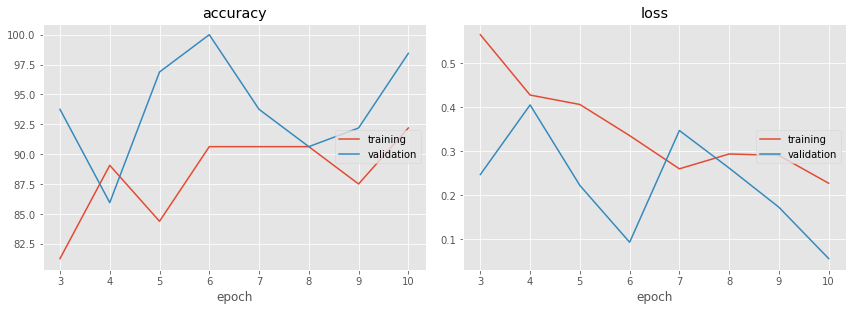

100%|██████████| 10/10 [29:07<00:00, 172.21s/it]

accuracy:
training   (min:   42.188, max:   92.188, cur:   92.188)
validation (min:   84.375, max:  100.000, cur:   98.438)

loss:
training   (min:    0.227, max:    1.838, cur:    0.227)
validation (min:    0.055, max:    0.557, cur:    0.055)


In [36]:
bert_clf_trainer.train_and_evaluate(bert_clf_model, train_data, val_data, optimizer, metrics, loss_fn=None, model_dir='./results/')

In [ ]:
bert_clf_pred = Predictor(device, model=bert_clf_model, max_seq_length=max_seq_len, tokenizer=tokenizer, X_proc=X_proc, target_int2label_dict=y_mvec.int2label_dict,
                         target_label2int_dict=y_mvec.label2int_dict)

In [ ]:
pred_label, pred_probability, probability = bert_clf_pred.predict(df=text_clf_df)
#print(pred_label, pred_probability, probability)

In [39]:
test_label = text_clf_df['label'].values
print(test_label.shape)

(3885,)


In [40]:
np.unique(pred_label)

array(['客户抱怨', '施压警告', '无还款能力', '有意愿还款', '核资', '表明来意'], dtype='<U5')

In [42]:
print(test_label[:10],'\n', pred_label[:10])

['表明来意' '有意愿还款' '表明来意' '表明来意' '核资' '有意愿还款' '表明来意' '有助于还款' '核资' '核资'] 
 ['施压警告', '客户抱怨', '核资', '有意愿还款', '表明来意', '核资', '表明来意', '无还款能力', '客户抱怨', '施压警告']


In [ ]:
# import scikitplot as skplot

# skplot.metrics.plot_confusion_matrix(test_label, pred_label, normalize=True, figsize=(8,6))
# skplot.metrics.plot_roc(test_label, probability.cpu(), figsize=(8,6))
# skplot.metrics.plot_precision_recall(test_label, probability.cpu(), figsize=(8,6))

# Bert For Sequence Label (NER Task)

In [ ]:
class BertForNER(BertPreTrainedModel):
    """BERT model for token-level classification.
    This module is composed of the BERT model with a linear layer on top of
    the full hidden state of the last layer.

    Params:
        `config`: a BertConfig class instance with the configuration to build a new model.
        `num_labels`: the number of classes for the classifier. Default = 2.

    Inputs:
        `input_ids`: a torch.LongTensor of shape [batch_size, sequence_length]
            with the word token indices in the vocabulary(see the tokens preprocessing logic in the scripts
            `extract_features.py`, `run_classifier.py` and `run_squad.py`)
        `token_type_ids`: an optional torch.LongTensor of shape [batch_size, sequence_length] with the token
            types indices selected in [0, 1]. Type 0 corresponds to a `sentence A` and type 1 corresponds to
            a `sentence B` token (see BERT paper for more details).
        `attention_mask`: an optional torch.LongTensor of shape [batch_size, sequence_length] with indices
            selected in [0, 1]. It's a mask to be used if the input sequence length is smaller than the max
            input sequence length in the current batch. It's the mask that we typically use for attention when
            a batch has varying length sentences.
        `labels`: labels for the classification output: torch.LongTensor of shape [batch_size, sequence_length]
            with indices selected in [0, ..., num_labels].

    Outputs:
        if `labels` is not `None`:
            Outputs the CrossEntropy classification loss of the output with the labels.
        if `labels` is `None`:
            Outputs the classification logits of shape [batch_size, sequence_length, num_labels].

    Example usage:
    ```python
    # Already been converted into WordPiece token ids
    input_ids = torch.LongTensor([[31, 51, 99], [15, 5, 0]])
    input_mask = torch.LongTensor([[1, 1, 1], [1, 1, 0]])
    token_type_ids = torch.LongTensor([[0, 0, 1], [0, 1, 0]])

    config = BertConfig(vocab_size_or_config_json_file=32000, hidden_size=768,
        num_hidden_layers=12, num_attention_heads=12, intermediate_size=3072)

    num_labels = 2

    model = BertForTokenClassification(config, num_labels)
    logits = model(input_ids, token_type_ids, input_mask)
    ```
    """
    def __init__(self, config, params):
        super(BertForNER, self).__init__(config)
        self.n_labels = params['n_labels']
        
        self.bert = BertModel(config)
        self.dropout = nn.Dropout(config.hidden_dropout_prob)
        self.classifier = nn.Linear(config.hidden_size, self.n_labels)
        self.apply(self.init_bert_weights)

    def forward(self, input_ids, token_type_ids=None, attention_mask=None, labels=None):
        """
        Args:
          input_ids: (batch, seq_len), word index of text, start with [CLS] and end with [SEP] token ids
          token_type_ids: (batch, seq_len), values from [0,1], indicates whether it's from sentence A(0) or B(1)
          attention_mask: (batch, seq_len), mask for input text, values from [0,1], 1 means word is padded
          labels: (batch), y 
        """
        sequence_output, _ = self.bert(input_ids, token_type_ids, attention_mask, output_all_encoded_layers=False)
        logging.info('bert ner: sequence_output shape {}'.format(sequence_output.shape))
        sequence_output = self.dropout(sequence_output)
        
        # final prediction layer
        self.logits = self.classifier(sequence_output)
        logging.info('bert ner: logits shape {}'.format(self.logits.shape))
        
        # to do: add crf layer
        

        if labels is not None:
            loss_fn = nn.CrossEntropyLoss()
            # Only keep active parts of the loss
            if attention_mask is not None:
                active_loss = attention_mask.view(-1) == 1
                active_logits = logits.view(-1, self.num_labels)[active_loss]
                active_labels = labels.view(-1)[active_loss]
                self.loss = loss_fn(active_logits, active_labels)
            else:
                self.loss = loss_fn(logits.view(-1, self.num_labels), labels.view(-1))
            return self.loss
        else:
            return self.logits


In [ ]:
params = {'n_labels':n_labels, 'label_map':label_map, 'batch_size':16, 'n_epochs':10, 'seq_len':max_seq_len, 'n_workers':-1, 'lr':0.0001}

In [ ]:
bert_ner_model = BertForTextClassification.from_pretrained('bert-base-chinese', params)
bert_ner_model.to(device)

# Bert For Entity Relation Extraction

In [2]:
class BertForEntityRelation(BertPreTrainedModel):
  """
  Bert for Entity Relation Extraction Task
  """
  def __init__(self, config, params):
    super(BertForEntityRelation, self).__init__(config)
    self.n_labels = params['n_labels']
    
    self.bert = BertModel(config)
    self.dropout = nn.Dropout(config.hidden_dropout_prob)
    self.classifier = nn.Linear(config.hidden_size, self.n_labels)
    self.apply(self.init_bert_weights)
    
    
  def forward(self, input_ids, token_type_ids=None, attention_mask=None, labels=None):
        """
        Args:
          input_ids: (batch, seq_len), word index of text, start with [CLS] and end with [SEP] token ids
          token_type_ids: (batch, seq_len), values from [0,1], indicates whether it's from sentence A(0) or B(1)
          attention_mask: (batch, seq_len), mask for input text, values from [0,1], 1 means word is padded
          labels: (batch), y 
        """
        _, pooled_output = self.bert(input_ids, token_type_ids, attention_mask,
                                     output_all_encoded_layers=False)
        logging.info('bert phrase sim: pooled_output shape {}'.format(pooled_output))
        #seq_relationship_score = self.cls( pooled_output)

        pooled_output = self.dropout(pooled_output)
        
        # final prediction layer
        self.logits = self.classifier(pooled_output)
        logging.info('text clf: logits {}'.format(self.logits.shape))
        
        if self.n_labels > 2:
          self.prediction_result = F.softmax(self.logits, dim=-1)
        else:
          self.prediction_result = F.sigmoid(self.logits)
        
        if labels is not None:
            loss_fn = nn.CrossEntropyLoss(ignore_index=-1)
            self.loss = loss_fn(self.logits.view(-1, self.n_labels), labels.view(-1))
            return self.loss
        else:
            return self.logits
    
    

NameError: ignored

In [3]:
params = {'n_labels':n_labels, 'label_map':label_map, 'batch_size':16, 'n_epochs':10, 'seq_len':max_seq_len, 'n_workers':-1, 'lr':0.0001}

NameError: ignored

# Bert For Phrase Sim Task 

In [ ]:
class BertForPhraseSim(BertPreTrainedModel):
    """
    Bert For Phrase similarity Task
    """
    def __init__(self, config, params):
        super(BertForPhraseSim, self).__init__(config)
        self.n_labels = params['n_labels']
        
        self.bert = BertModel(config)
        self.dropout = nn.Dropout(config.hidden_dropout_prob)
        self.classifier = nn.Linear(config.hidden_size, self.n_labels)
        self.apply(self.init_bert_weights)

    def forward(self, input_ids, token_type_ids=None, attention_mask=None, labels=None):
        """
        Args:
          input_ids: (batch, seq_len), word index of text, start with [CLS] and end with [SEP] token ids
          token_type_ids: (batch, seq_len), values from [0,1], indicates whether it's from sentence A(0) or B(1)
          attention_mask: (batch, seq_len), mask for input text, values from [0,1], 1 means word is padded
          labels: (batch), y 
        """
        _, pooled_output = self.bert(input_ids, token_type_ids, attention_mask,
                                     output_all_encoded_layers=False)
        logging.info('bert phrase sim: pooled_output shape {}'.format(pooled_output))
        #seq_relationship_score = self.cls( pooled_output)

        pooled_output = self.dropout(pooled_output)
        
        # final prediction layer
        self.logits = self.classifier(pooled_output)
        logging.info('text clf: logits {}'.format(self.logits.shape))
        
        if self.n_labels > 2:
          self.prediction_result = F.softmax(self.logits, dim=-1)
        else:
          self.prediction_result = F.sigmoid(self.logits)
        
        if labels is not None:
            loss_fn = nn.CrossEntropyLoss(ignore_index=-1)
            self.loss = loss_fn(self.logits.view(-1, self.n_labels), labels.view(-1))
            return self.loss
        else:
            return self.logits


In [ ]:
ps_proc = TextPhraseSimProcessor(labels=None, feature_columns=['passage', 'question'], label_columns='is_selected')

train_examples = ps_proc.get_train_examples(df=ucac_train_df, size=1000, labels_available=True)
dev_examples = ps_proc.get_dev_examples(df=ucac_train_df, size=1000)

In [51]:
print(max_seq_len)

406


In [52]:
label_map = {0:0, 1:1}

train_data = get_batch(train_examples, label_map, max_seq_len, tokenizer, output_mode="classification", label_available=True, batch_size=32, num_workers=-1)
val_data = get_batch(dev_examples, label_map, max_seq_len, tokenizer, output_mode="classification", label_available=True, batch_size=32, num_workers=-1)

INFO:root:Writing example 0 of 1000
INFO:root:*** Example ***
INFO:root:guid: 991276
INFO:root:tokens: [CLS] 黑 芝 麻 到 底 可 以 和 蜂 蜜 一 起 吃 吗 黑 芝 麻 是 一 种 非 常 不 错 的 补 品 ， 老 年 人 经 常 吃 一 些 黑 芝 麻 可 以 有 效 的 调 节 我 们 自 身 出 现 的 白 头 发 的 问 题 ， 帮 助 我 们 去 除 黑 色 素 。 经 常 性 的 吃 一 些 蜂 蜜 ， 对 于 我 们 自 身 的 嗓 子 也 会 有 很 大 的 好 处 ， 还 可 以 帮 助 领 略 蜂 蜜 的 美 味 ， 详 细 的 为 大 家 介 绍 一 下 黑 芝 麻 可 以 和 蜂 蜜 一 起 吃 吗 呢 。 [SEP] 黑 芝 麻 可 以 放 蜂 蜜 吗 [SEP]
INFO:root:input_ids: 101 7946 5698 7937 1168 2419 1377 809 1469 6044 6057 671 6629 1391 1408 7946 5698 7937 3221 671 4905 7478 2382 679 7231 4638 6133 1501 8024 5439 2399 782 5307 2382 1391 671 763 7946 5698 7937 1377 809 3300 3126 4638 6444 5688 2769 812 5632 6716 1139 4385 4638 4635 1928 1355 4638 7309 7579 8024 2376 1221 2769 812 1343 7370 7946 5682 5162 511 5307 2382 2595 4638 1391 671 763 6044 6057 8024 2190 754 2769 812 5632 6716 4638 1624 2094 738 833 3300 2523 1920 4638 1962 1905 8024 6820 1377 809 2376 1221 7566 4526 6044 6057 4638 5401 1456 8024 6422 5301 4638 711 1920 2157 

0
0
1
0
0
0
0
0
0
0
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
1
0
1
0
0
1
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
0
0
0
0
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
0
0
0
0
0
1
0
0
1
1
0
0
0
0
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
1
0
0
0
0
0
0
0
1
1
0
0
0
0
0
1
0
0
0
0
0
0
1
0
0
0
0
0
0
0
0
0
0
1
0
0
1
0
0
0
1
0
1
0
0
0
0
0
0
0
0
0
1
1
0
1
0
0
0
0
0
0
0
0
0
1
0
1
0
0
1
0
0
0
0
0
1
0
0
0
0
0
1
1
0
1
0
1
0
0
0
0
0
0
0
0
0
1
1
1
0
0
0
0
0
0
0
1
0
0
0
1
0
0
0
0
0
0
0
0
0
0
0
0
0
1
0
1
0
1
1
1
1
0
0
0
0
0
1
0
0
0
0
0
1
0
0
0
0
0
0
0
1
0
0
1
0
0
0
1
0
0
0
0
0
0
0
1
0
1
0
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
1
1
0
0
0
0
0
0
0
0
1
1
0
0
0
0
0
0
0
0
1
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
0
0
0
0
0
1
0
1
1
1
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
0
0
1
0
1
0
0
0
0
0
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
0
0
0
1
0
0
0
0
0
0
0
0
0
1
0
0
0
0
0
0
0
0
0
0
0
0
1
0
1
1
1
1
0
1
0
0
0
0
0
0
0
1
0
0
0
0
1
0
0
0
0
1
0
1
0
0
0
1
0
0
0
0
0
0
0
0
1
0
0
0
0
1
0
0
0
0
1
0
0
0
0
0
0
0
1
0
0
0
0
0
0
0
0
1
0
0
0
0
0
0


INFO:root:Writing example 0 of 1000
INFO:root:*** Example ***
INFO:root:guid: 715161
INFO:root:tokens: [CLS] 己 未 日 ， 己 未 日 柱 命 理 分 析 3 ） 因 此 ， 己 未 日 出 生 的 男 性 ， 有 出 生 于 大 家 族 之 兆 ， 在 人 生 路 上 能 有 大 发 展 。 若 从 事 工 商 ， 定 有 分 厂 、 分 公 司 或 者 分 店 。 所 娶 的 妻 子 ， 也 很 贤 淑 。 4 ） 己 未 日 出 生 的 女 性 ， 其 父 亲 的 运 气 很 有 可 能 不 好 。 己 未 日 个 人 则 会 在 结 婚 后 运 气 逐 渐 走 好 。 但 是 容 易 产 生 感 情 困 扰 和 苦 恼 。 己 未 日 出 生 的 女 性 ， 容 易 和 有 过 婚 恋 史 的 男 性 结 婚 。 也 容 易 和 婚 恋 关 系 尚 且 存 续 的 男 士 发 生 感 情 纠 葛 。 所 以 希 望 己 未 日 出 生 的 女 性 ， 面 对 男 女 感 情 时 要 多 一 份 谨 慎 。 5 ） 但 是 ， 总 体 说 来 ， 己 未 日 出 生 的 人 ， 无 论 男 女 ， 都 有 为 人 稳 重 的 一 面 。 处 事 有 分 寸 ， 自 重 ， 具 有 进 取 心 。 没 有 非 分 的 欲 望 ， 但 处 世 不 免 有 猜 疑 心 。 因 此 ， 在 特 定 的 时 空 条 件 下 ， 出 现 自 讨 苦 吃 的 尴 尬 。 6 ） 己 未 日 出 生 的 人 ， 无 论 男 女 ， 和 属 蛇 、 属 马 的 人 ， 容 易 走 到 一 起 。 但 若 真 有 这 样 的 友 谊 出 现 ， 则 会 让 己 未 日 出 生 的 人 ， 更 加 自 我 封 闭 ， 更 加 缺 乏 生 发 、 创 造 之 意 ， 7 ） 己 未 日 出 生 的 人 ， 无 论 男 女 ， 和 属 猪 、 属 兔 的 人 ， 也 容 易 [SEP] 己 未 日 和 戊 戌 日 合 吗 [SEP]


0
0
0
0
0
0
0
0
0
0
0
0
0
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
0
1
0
0
0
0


INFO:root:input_ids: 101 2346 3313 3189 8024 2346 3313 3189 3393 1462 4415 1146 3358 124 8021 1728 3634 8024 2346 3313 3189 1139 4495 4638 4511 2595 8024 3300 1139 4495 754 1920 2157 3184 722 1042 8024 1762 782 4495 6662 677 5543 3300 1920 1355 2245 511 5735 794 752 2339 1555 8024 2137 3300 1146 1322 510 1146 1062 1385 2772 5442 1146 2421 511 2792 2034 4638 1988 2094 8024 738 2523 6570 3902 511 125 8021 2346 3313 3189 1139 4495 4638 1957 2595 8024 1071 4266 779 4638 6817 3698 2523 3300 1377 5543 679 1962 511 2346 3313 3189 702 782 1156 833 1762 5310 2042 1400 6817 3698 6852 3933 6624 1962 511 852 3221 2159 3211 772 4495 2697 2658 1737 2817 1469 5736 2630 511 2346 3313 3189 1139 4495 4638 1957 2595 8024 2159 3211 1469 3300 6814 2042 2605 1380 4638 4511 2595 5310 2042 511 738 2159 3211 1469 2042 2605 1068 5143 2213 684 2100 5330 4638 4511 1894 1355 4495 2697 2658 5272 5867 511 2792 809 2361 3307 2346 3313 3189 1139 4495 4638 1957 2595 8024 7481 2190 4511 1957 2697 2658 3198 6206 1914 671

0
0
0
0
0
0
1
0
0
0
0
0
0
0
0
0
0
0
0
1
0
0
0
1
0
0
0
1
0
0
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
0
0
0
0
0
1
0
0
0
0
1
0
0
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
0
0
0
0
0
0
1
0
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
0
0
0
0
0
1
0
0
0
0
1
1
1
1
0
0
0
0
0
0
0
1
1
0
1
0
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
1
0
0
0
0
0
0
1
0
1
0
0
0
0
0
0
0
0
0
1
0
1
0
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
0
0
0
0
0
1
1
0
0
0
1
0
0
0
0
0
0
0
0
0
0
0
0
0
1
0
0
0
1
0
0
0
0
1
0
0
0
0
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
0
0
0
0
1
0
0
0
0
1
1
0
0
0
0
0
0
0
1
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
0
1
0
1
0
0
0
0
0
0
0
0
0
0
0
1
0
0
0
0
0
0
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
1
0
0
0
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
0
1
0
0
0
1
0
0
1
0
0
0
0
0
0
0
0
1
0
0
1
0
0
0
0
0
0
0
0
0
1
0
0
0
0
0
0
0
0
1
0
0
0
0
1
0
0
0
1
1
0
0
0
0
0
0
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
0
0
0
1
0
0
0
0
1
0
0
0
0
0
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
0
0
0
0
0
0
0
0
0
1
0
0
0
0
0
0
0
0
0
1
0


In [ ]:
params = {'n_labels':2, 'label_map':label_map, 'batch_size':16, 'n_epochs':10, 'seq_len':max_seq_len, 'n_workers':-1, 'lr':0.0001}

In [54]:
bert_phrase_model = BertForPhraseSim.from_pretrained('bert-base-chinese', params)
bert_phrase_model.to(device)

INFO:pytorch_pretrained_bert.file_utils:https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-chinese.tar.gz not found in cache, downloading to /tmp/tmpouc85y9q
100%|██████████| 382072689/382072689 [00:33<00:00, 11244285.38B/s]
INFO:pytorch_pretrained_bert.file_utils:copying /tmp/tmpouc85y9q to cache at /root/.cache/torch/pytorch_pretrained_bert/42d4a64dda3243ffeca7ec268d5544122e67d9d06b971608796b483925716512.02ac7d664cff08d793eb00d6aac1d04368a1322435e5fe0a27c70b0b3a85327f
INFO:pytorch_pretrained_bert.file_utils:creating metadata file for /root/.cache/torch/pytorch_pretrained_bert/42d4a64dda3243ffeca7ec268d5544122e67d9d06b971608796b483925716512.02ac7d664cff08d793eb00d6aac1d04368a1322435e5fe0a27c70b0b3a85327f
INFO:pytorch_pretrained_bert.file_utils:removing temp file /tmp/tmpouc85y9q
INFO:pytorch_pretrained_bert.modeling:loading archive file https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-chinese.tar.gz from cache at /root/.cache/torch/pytorch_pretrained_bert/42d4a

BertForPhraseSim(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(21128, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): BertLayerNorm()
      (dropout): Dropout(p=0.1)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): BertLayerNorm()
              (dropout): Dropout(p=0.1)
            )
          )
          (intermediate): BertInter

In [ ]:
loss_fn = F.cross_entropy

# maintain all metrics required in this dictionary- these are used in the training and evaluation loops
metrics = {
    'accuracy': accuracy,
    # could add more metrics such as accuracy for each token type
}

optimizer = optim.Adam(filter(lambda p: p.requires_grad, bert_phrase_model.parameters()), lr=params['lr'])

In [ ]:
bert_phrase_trainer = Trainer(device, batch_size=params['batch_size'], n_epochs=params['n_epochs'], min_clip_val=-1.0, max_clip_val=1.0)

In [57]:
bert_phrase_trainer.train_and_evaluate(bert_phrase_model, train_data, val_data, optimizer, metrics, loss_fn=None, model_dir='./results/')

  0%|          | 0/10 [00:00<?, ?it/s]INFO:root:Epoch 1/10

train_data_iter:   0%|          | 0/32 [00:00<?, ?it/s]



RuntimeError: ignored

# Bert Aspect Term Task

In [51]:
from pytorch_pretrained_bert import BertForSequenceClassification, BertModel

class BertForAspect(BertForSequenceClassification):
    """
    Bert For aspect term Task
    """
    def __init__(self, config, params):
        super(BertForAspect, self).__init__(config, params['n_labels'])
        self.n_labels = params['n_labels']
        
        self.bert = BertModel(config)
        self.dropout = nn.Dropout(config.hidden_dropout_prob)
        self.classifier = nn.Linear(config.hidden_size, self.n_labels)
        self.apply(self.init_bert_weights)
        
        self.multiheads = MultiHeadAttention(config.hidden_size, params['heads'], keep_prob=params['keep_prob'])

    def forward(self, input_ids, token_type_ids=None, attention_mask=None, labels=None):
        """
        Args:
          input_ids: (batch, seq_len), word index of text, start with [CLS] and end with [SEP] token ids
          token_type_ids: (batch, seq_len), values from [0,1], indicates whether it's from sentence A(0) or B(1)
          attention_mask: (batch, seq_len), mask for input text, values from [0,1], 1 means word is padded
          labels: (batch), y 
        """
        sequence_output, pooled_output = self.bert(input_ids, token_type_ids, attention_mask,
                                     output_all_encoded_layers=False)
        #logging.info('bert phrase sim: pooled_output shape {}'.format(pooled_output))
        logging.info('bert for aspect {}'.format(sequence_output.shape))    

        pooled_output = self.dropout(sequence_output)
        pooled_output = self.multiheads(pooled_output)
        logging.info('multihead pooled_output shape {}'.format(pooled_output.shape))
        
        # final prediction layer
        self.logits = self.classifier(pooled_output)
        logging.info('text clf: logits {}'.format(self.logits.shape))
        
        if self.n_labels > 2:
          self.prediction_result = F.softmax(self.logits, dim=-1)
        else:
          self.prediction_result = F.sigmoid(self.logits)
        
        if labels is not None:
            loss_fn = nn.CrossEntropyLoss(ignore_index=-1)
            self.loss = loss_fn(self.logits.view(-1, self.n_labels), labels.view(-1))
            return self.loss
        else:
            return self.logits

        
    def get_loss(self):
        return self.loss
    
    def get_prediction_result(self):
        return self.prediction_result
    
    def get_logits(self):
        return self.logits

In [52]:
class ScaledDotProductAttention(nn.Module):
    def __init__(self, keep_prob=0.1):
        super(ScaledDotProductAttention,self).__init__()
        self.keep_prob = keep_prob
        self.build_model()
        
    def build_model(self):
        self.dropout = nn.Dropout(self.keep_prob)
        
    def forward(self,query,key,value,mask=None):
        """
        Args:
            query: d_k
            key: d_k
            value: d_v
        """
        d_k = query.size(-1)
        scores = torch.matmul(query, key.transpose(-2,-1))/math.sqrt(d_k)
        logging.info('scores shape {}'.format(scores.shape))
        if mask is not None:
            scores = scores.masked_fill(mask==0,-1e9)
        p_attn = F.softmax(scores,dim=-1)
        if self.dropout is not None:
            p_attn = self.dropout(p_attn)
        return torch.matmul(p_attn,value), p_attn
    

def clones(module, N):
    """
    Produce N identical layers
    """
    from copy import deepcopy
    return nn.ModuleList([deepcopy(module) for _ in range(N)])


class MultiHeadAttention(nn.Module):
    """
    multihead attention, h is number of heads
    """
    def __init__(self, d_model, h, keep_prob=0.1):
        super(MultiHeadAttention,self).__init__()
        assert d_model%h == 0
        self.d_model = d_model
        self.h = h
        self.keep_prob = keep_prob
        self.d_k = self.d_model//self.h
        self.build_model()
        
    def build_model(self):
        self.dropout = nn.Dropout(self.keep_prob)
        self.linears = clones(nn.Linear(self.d_model,self.d_model), 4)
        self.scaleddotattn = ScaledDotProductAttention(self.keep_prob)
        self.attn = None
        
    def forward(self, inputs, mask=None):
        if mask is not None:
            # same mask applied to all h heads
            mask = mask.unsqueeze(1)
        #nbatches = query.size(0)
        #seq_len = query.size(1)
        seq_len = inputs.size(1)
        
        # first, do all the linear projections in batch from d_model to h*d_k
        query,key,value = [l(x).view(-1,seq_len,self.h,self.d_k).transpose(1,2) for l,x in zip(self.linears,(inputs, inputs, inputs))]
        # second, apply attention on all the projected vectors in batch
        x,self.attn = self.scaleddotattn(query,key,value,mask)
        # third, concat using a view and apply a final linear
        x = x.transpose(1,2).contiguous().view(-1,seq_len,self.h*self.d_k)
        return self.linears[-1](x)
    
    
class LayerNorm(nn.Module):
    """
    There is implementation in nn.LayerNorm
    """
    def __init__(self,features,eps=1e-6):
        super(LayerNorm,self).__init__()
        self.features = features
        self.eps = eps
        self.build_model()
        
    def build_model(self):
        self.a_2 = nn.Parameter(torch.ones(self.features))
        self.b_2 = nn.Parameter(torch.zeros(self.features))
        
    def forward(self, x):
        mean = x.mean(-1,keepdim=True)
        std = x.std(-1,keepdim=True)
        return self.a_2*(x-mean)/(std + self.eps)+self.b_2

In [53]:
ps_proc = TextPhraseSimProcessor(labels=None, feature_columns=['sent', 'term'], label_columns='polarity')

train_examples = ps_proc.get_train_examples(df=laptop_train_df, size=1000, labels_available=True)
dev_examples = ps_proc.get_dev_examples(df=laptop_train_df, size=1000)

In [54]:
from pytorch_pretrained_bert import BertTokenizer

In [55]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

INFO:pytorch_pretrained_bert.tokenization:loading vocabulary file https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-uncased-vocab.txt from cache at /Users/hqian/.pytorch_pretrained_bert/26bc1ad6c0ac742e9b52263248f6d0f00068293b33709fae12320c0e35ccfbbb.542ce4285a40d23a559526243235df47c5f75c197f04f37d1a0c124c32c9a084


In [56]:
train_data = get_batch(train_examples, label_map, max_seq_len, tokenizer, output_mode="classification", label_available=True, batch_size=32, num_workers=-1)
val_data = get_batch(dev_examples, label_map, max_seq_len, tokenizer, output_mode="classification", label_available=True, batch_size=32, num_workers=-1)

INFO:root:Writing example 0 of 1000
INFO:root:*** Example ***
INFO:root:guid: 1351
INFO:root:tokens: [CLS] the machine has a blur ##ay player the book has no mention of it or how to connect it to your hd ##tv . [SEP] blur ##ay player [SEP]
INFO:root:input_ids: 101 1996 3698 2038 1037 14819 4710 2447 1996 2338 2038 2053 5254 1997 2009 2030 2129 2000 7532 2009 2000 2115 10751 9189 1012 102 14819 4710 2447 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0

0
-1
-1
1
1
-1
1
1
-1
1
-1
-1
-1
-1
-1
0
-1
-1
0
1
-1
-1
-1
0
1
1
1
0
-1
-1
-1
1
0
0
1
0
1
-1
1
1
-1
-1
-1
1
0
-1
-1
0
-1
0
1
1
-1
1
1
1
1
1
1
1
-1
1
-1
1
1
-1
0
0
-1
-1
0
-1
0
-1
1
1
1
1
1
0
1
-1
0
0
0
1
-1
-1
1
0
-1
-1
-1
1
1
0
0
1
-1
1
1
1
1
-1
0
1
0
1
0
-1
1
-1
0
0
0
0
1
-1
1
-1
1
0
-1
1
1
1
-1
-1
0
1
-1
0
-1
-1
-1
-1
0
1
1
-1
-1
-1
1
1
-1
-1
1
1
1
1
1
0
1
-1
0
-1
1
-1
-1
1
1
-1
1
-1
-1
-1
-1
1
1
-1
0
-1
1
1
0
-1
0
-1
1
1
-1
1
1
1
1
1
1
1
0
0
0
1
1
1
-1
1
-1
-1
-1
0
1
-1
-1
-1
-1
-1
1
1
-1
-1
1
-1
-1
1
1
1
0
1
0
0
-1
0
-1
0
-1
-1
1
-1
1
0
0
-1
-1
-1
0
1
1
1
0
-1
1
1
1
0
-1
1
1
0
-1
-1
1
0
1
1
0
-1
1
1
-1
1
-1
1
-1
1
0
-1
-1
1
1
1
-1
0
0
-1
1
1
0
1
-1
1
1
0
-1
1
1
-1
1
1
-1
-1
-1
1
-1
1
1
-1
1
-1
0
1
0
1
-1
1
1
1
1
0
-1
1
0
-1
1
1
-1
0
-1
-1
1
-1
-1
1
1
1
1
1
-1
-1
1
0
1
1
1
0
-1
-1
-1
1
-1
-1
1
0
0
1
1
-1
1
0
1
-1
-1
1
-1
-1
-1
-1
-1
0
1
1
1
1
0
-1
-1
0
1
1
-1
1
-1
0
-1
1
1
1
0
1
1
-1
1
-1
-1
0
1
0
0
-1
-1
-1
-1
-1
-1
1
-1
-1
1
0
1
0
1
1
1
1
0
1
0
-1
0
-1
1
-1
0
-1
1
1
-1
0
-1
1
1


INFO:root:Writing example 0 of 1000
INFO:root:*** Example ***
INFO:root:guid: 442
INFO:root:tokens: [CLS] i connect a lac ##ie 2 ##bi ##g external drive via the fire ##wire 800 interface , which is useful for time machine . [SEP] fire ##wire 800 interface [SEP]
INFO:root:input_ids: 101 1045 7532 1037 18749 2666 1016 5638 2290 6327 3298 3081 1996 2543 20357 5385 8278 1010 2029 2003 6179 2005 2051 3698 1012 102 2543 20357 5385 8278 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 


1
-1
1
-1
0
1
-1
0
1
1
-1
1
-1
1
-1
-1
1
0
1
0
1
1
-1
-1
1
1
-1
1
-1
1
-1
-1
-1
-1
0
1
-1
-1
-1
-1
-1
0
0
-1
-1
1
0
1
1
0
1
0
0
-1
1
-1
1
1
0
1
-1
1
1
1
1
1
1
-1
-1
1
0
-1
-1
-1
1
-1
-1
-1
-1
-1
-1
-1
-1
0
1
0
-1
0
-1
1
0
1
1
0
-1
0
-1
1
1
-1
1
1
1
-1
1
-1
-1
-1
-1
0
0
0
0
1
0
1
-1
0
0
0
1
-1
0
0
-1
1
1
-1
1
-1
1
1
1
-1
-1
1
1
-1
1
1
-1
-1
-1
0
0
1
-1
1
1
-1
1
-1
-1
-1
1
-1
-1
0
1
1
1
1
-1
1
-1
-1
1
-1
1
0
0
1
1
1
-1
1
-1
1
1
0
1
0
0
-1
0
1
1
-1
0
1
1
-1
0
-1
-1
1
1
1
-1
1
1
0
1
0
-1
1
1
1
1
0
-1
-1
1
1
1
1
1
-1
-1
-1
1
1
1
1
-1
1
1
1
0
1
1
1
1
1
0
1
1
-1
1
0
0
0
-1
0
1
-1
0
1
0
-1
1
1
-1
1
1
1
1
1
-1
0
-1
-1
1
1
-1
0
0
-1
0
-1
1
1
1
1
-1
1
0
-1
0
-1
1
0
1
-1
0
-1
-1
-1
-1
-1
1
1
1
1
0
1
-1
0
0
-1
-1
0
-1
-1
1
1
1
-1
0
1
1
1
1
0
-1
0
-1
0
0
1
-1
0
1
1
-1
0
0
0
-1
-1
1
-1
0
-1
-1
1
-1
0
0
-1
-1
-1
1
0
-1
1
1
-1
0
1
0
0
1
1
-1
-1
0
0
1
1
1
-1
1
1
0
-1
-1
-1
1
-1
1
-1
-1
1
-1
-1
-1
-1
-1
0
-1
0
1
1
-1
1
-1
1
1
-1
1
1
-1
1
-1
1
1
1
1
0
0
1
1
0
-1
-1
-1
0
1
0
1
1
1
0
-1
-1
-1
1
1
-1
0
1
1


In [57]:
params = {'n_labels':3, 'label_map':label_map, 'batch_size':16, 'n_epochs':10, 'seq_len':max_seq_len, 'n_workers':-1, 'lr':0.0001, 'keep_prob':0.1, 'heads':12}

In [58]:
device = torch.device('cpu')

In [59]:
bert_aspect_model = BertForAspect.from_pretrained('bert-base-uncased', params)

bert_aspect_model.to(device)

INFO:pytorch_pretrained_bert.modeling:loading archive file https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-uncased.tar.gz from cache at /Users/hqian/.pytorch_pretrained_bert/9c41111e2de84547a463fd39217199738d1e3deb72d4fec4399e6e241983c6f0.ae3cef932725ca7a30cdcb93fc6e09150a55e2a130ec7af63975a16c153ae2ba
INFO:pytorch_pretrained_bert.modeling:extracting archive file /Users/hqian/.pytorch_pretrained_bert/9c41111e2de84547a463fd39217199738d1e3deb72d4fec4399e6e241983c6f0.ae3cef932725ca7a30cdcb93fc6e09150a55e2a130ec7af63975a16c153ae2ba to temp dir /var/folders/l_/cs7qvzls637f1fpbpkkny2_c0000gn/T/tmp1pba4kx1
INFO:pytorch_pretrained_bert.modeling:Model config {
  "attention_probs_dropout_prob": 0.1,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "max_position_embeddings": 512,
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "type_vocab_size": 2,
  "vocab_size": 30522
}

INFO:pytorch_p

BertForAspect(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): BertLayerNorm()
      (dropout): Dropout(p=0.1)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): BertLayerNorm()
              (dropout): Dropout(p=0.1)
            )
          )
          (intermediate): BertIntermed

In [60]:
loss_fn = F.cross_entropy

# maintain all metrics required in this dictionary- these are used in the training and evaluation loops
metrics = {
    'accuracy': accuracy,
    # could add more metrics such as accuracy for each token type
}

optimizer = optim.Adam(filter(lambda p: p.requires_grad, bert_aspect_model.parameters()), lr=params['lr'])

In [63]:
bert_aspect_trainer = Trainer(device, batch_size=params['batch_size'], n_epochs=params['n_epochs'], min_clip_val=-1.0, max_clip_val=1.0)

In [64]:
bert_aspect_trainer.train_and_evaluate(bert_aspect_model, train_data, val_data, optimizer, metrics, loss_fn=None, model_dir='./results/')



  0%|          | 0/10 [00:00<?, ?it/s]INFO:root:Epoch 1/10



train_data_iter:   0%|          | 0/32 [00:00<?, ?it/s]INFO:root:bert for aspect torch.Size([32, 474, 768])


TypeError: forward() missing 2 required positional arguments: 'key' and 'value'

# Bert For QA Task

In [ ]:
class BertForQuestionAnswering(BertPreTrainedModel):
    """BERT model for Question Answering (span extraction).
    This module is composed of the BERT model with a linear layer on top of
    the sequence output that computes start_logits and end_logits

    Params:
        `config`: a BertConfig class instance with the configuration to build a new model.

    Inputs:
        `input_ids`: a torch.LongTensor of shape [batch_size, sequence_length]
            with the word token indices in the vocabulary(see the tokens preprocessing logic in the scripts
            `extract_features.py`, `run_classifier.py` and `run_squad.py`)
        `token_type_ids`: an optional torch.LongTensor of shape [batch_size, sequence_length] with the token
            types indices selected in [0, 1]. Type 0 corresponds to a `sentence A` and type 1 corresponds to
            a `sentence B` token (see BERT paper for more details).
        `attention_mask`: an optional torch.LongTensor of shape [batch_size, sequence_length] with indices
            selected in [0, 1]. It's a mask to be used if the input sequence length is smaller than the max
            input sequence length in the current batch. It's the mask that we typically use for attention when
            a batch has varying length sentences.
        `start_positions`: position of the first token for the labeled span: torch.LongTensor of shape [batch_size].
            Positions are clamped to the length of the sequence and position outside of the sequence are not taken
            into account for computing the loss.
        `end_positions`: position of the last token for the labeled span: torch.LongTensor of shape [batch_size].
            Positions are clamped to the length of the sequence and position outside of the sequence are not taken
            into account for computing the loss.

    Outputs:
        if `start_positions` and `end_positions` are not `None`:
            Outputs the total_loss which is the sum of the CrossEntropy loss for the start and end token positions.
        if `start_positions` or `end_positions` is `None`:
            Outputs a tuple of start_logits, end_logits which are the logits respectively for the start and end
            position tokens of shape [batch_size, sequence_length].

    Example usage:
    ```python
    # Already been converted into WordPiece token ids
    input_ids = torch.LongTensor([[31, 51, 99], [15, 5, 0]])
    input_mask = torch.LongTensor([[1, 1, 1], [1, 1, 0]])
    token_type_ids = torch.LongTensor([[0, 0, 1], [0, 1, 0]])

    config = BertConfig(vocab_size_or_config_json_file=32000, hidden_size=768,
        num_hidden_layers=12, num_attention_heads=12, intermediate_size=3072)

    model = BertForQuestionAnswering(config)
    start_logits, end_logits = model(input_ids, token_type_ids, input_mask)
    ```
    """
    def __init__(self, config):
        super(BertForQuestionAnswering, self).__init__(config)
        self.bert = BertModel(config)
        # TODO check with Google if it's normal there is no dropout on the token classifier of SQuAD in the TF version
        # self.dropout = nn.Dropout(config.hidden_dropout_prob)
        self.qa_outputs = nn.Linear(config.hidden_size, 2)
        self.apply(self.init_bert_weights)

    def forward(self, input_ids, token_type_ids=None, attention_mask=None, start_positions=None, end_positions=None):
        sequence_output, _ = self.bert(input_ids, token_type_ids, attention_mask, output_all_encoded_layers=False)
        logits = self.qa_outputs(sequence_output)
        start_logits, end_logits = logits.split(1, dim=-1)
        start_logits = start_logits.squeeze(-1)
        end_logits = end_logits.squeeze(-1)

        if start_positions is not None and end_positions is not None:
            # If we are on multi-GPU, split add a dimension
            if len(start_positions.size()) > 1:
                start_positions = start_positions.squeeze(-1)
            if len(end_positions.size()) > 1:
                end_positions = end_positions.squeeze(-1)
            # sometimes the start/end positions are outside our model inputs, we ignore these terms
            ignored_index = start_logits.size(1)
            start_positions.clamp_(0, ignored_index)
            end_positions.clamp_(0, ignored_index)

            loss_fct = CrossEntropyLoss(ignore_index=ignored_index)
            start_loss = loss_fct(start_logits, start_positions)
            end_loss = loss_fct(end_logits, end_positions)
            total_loss = (start_loss + end_loss) / 2
            return total_loss
        else:
            return start_logits, end_logits


# Bert Multiple choice Task

In [ ]:
class BertForMultipleChoice(BertPreTrainedModel):
    """BERT model for multiple choice tasks.
    This module is composed of the BERT model with a linear layer on top of
    the pooled output.

    Params:
        `config`: a BertConfig class instance with the configuration to build a new model.
        `num_choices`: the number of classes for the classifier. Default = 2.

    Inputs:
        `input_ids`: a torch.LongTensor of shape [batch_size, num_choices, sequence_length]
            with the word token indices in the vocabulary(see the tokens preprocessing logic in the scripts
            `extract_features.py`, `run_classifier.py` and `run_squad.py`)
        `token_type_ids`: an optional torch.LongTensor of shape [batch_size, num_choices, sequence_length]
            with the token types indices selected in [0, 1]. Type 0 corresponds to a `sentence A`
            and type 1 corresponds to a `sentence B` token (see BERT paper for more details).
        `attention_mask`: an optional torch.LongTensor of shape [batch_size, num_choices, sequence_length] with indices
            selected in [0, 1]. It's a mask to be used if the input sequence length is smaller than the max
            input sequence length in the current batch. It's the mask that we typically use for attention when
            a batch has varying length sentences.
        `labels`: labels for the classification output: torch.LongTensor of shape [batch_size]
            with indices selected in [0, ..., num_choices].

    Outputs:
        if `labels` is not `None`:
            Outputs the CrossEntropy classification loss of the output with the labels.
        if `labels` is `None`:
            Outputs the classification logits of shape [batch_size, num_labels].

    Example usage:
    ```python
    # Already been converted into WordPiece token ids
    input_ids = torch.LongTensor([[[31, 51, 99], [15, 5, 0]], [[12, 16, 42], [14, 28, 57]]])
    input_mask = torch.LongTensor([[[1, 1, 1], [1, 1, 0]],[[1,1,0], [1, 0, 0]]])
    token_type_ids = torch.LongTensor([[[0, 0, 1], [0, 1, 0]],[[0, 1, 1], [0, 0, 1]]])
    config = BertConfig(vocab_size_or_config_json_file=32000, hidden_size=768,
        num_hidden_layers=12, num_attention_heads=12, intermediate_size=3072)

    num_choices = 2

    model = BertForMultipleChoice(config, num_choices)
    logits = model(input_ids, token_type_ids, input_mask)
    ```
    """
    def __init__(self, config, params):
        super(BertForMultipleChoice, self).__init__(config)
        self.n_choices = params['n_choices']
        
        self.bert = BertModel(config)
        self.dropout = nn.Dropout(config.hidden_dropout_prob)
        self.classifier = nn.Linear(config.hidden_size, 1) # 1 or n_labels
        self.apply(self.init_bert_weights)

    def forward(self, input_ids, token_type_ids=None, attention_mask=None, labels=None):
        """
        Args:
          input_ids: (batch, seq_len), word index of text, start with [CLS] and end with [SEP] token ids
          token_type_ids: (batch, seq_len), values from [0,1], indicates whether it's from sentence A(0) or B(1)
          attention_mask: (batch, seq_len), mask for input text, values from [0,1], 1 means word is padded
          labels: (batch), y 
        """
        flat_input_ids = input_ids.view(-1, input_ids.size(-1))
        flat_token_type_ids = token_type_ids.view(-1, token_type_ids.size(-1)) if token_type_ids is not None else None
        flat_attention_mask = attention_mask.view(-1, attention_mask.size(-1)) if attention_mask is not None else None
        logging.info('flat_input_ids shape {}, flat_token_type_ids shape {}, flat_attention_mask shape {}'.format(flat_input_ids.shape, flat_token_type_ids.shape, flat_attention_mask.shape))
        
        _, pooled_output = self.bert(flat_input_ids, flat_token_type_ids, flat_attention_mask, output_all_encoded_layers=False)
        logging.info('pooled_output shape {}'.format(pooled_output.shape))
        pooled_output = self.dropout(pooled_output)
        
        # final prediction layer
        logits = self.classifier(pooled_output)
        self.logits = logits.view(-1, self.num_choices)

        if labels is not None:
            loss_fn = CrossEntropyLoss()
            self.loss = loss_fn(self.logits, labels)
            return self.loss
        else:
            return self.logits
          